In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import statsmodels.api as sm
#import mplcursors
from pylab import rcParams
from matplotlib.backends.backend_agg import FigureCanvasAgg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

plt.style.use('seaborn-darkgrid')

In [2]:
HPSDF = pd.read_csv('COVID_HPS.csv', index_col = 0)
HPSDF.head()

,State,cases,deaths,Personal Health Care Expenses Per State (2014),Hospital Services Expenses Per State (2014),Physician and Clinical Services Expenses Per State (2014),Other Professional Services Expenses Per State (2014),Home Health Care Expenses Per State (2014),Drugs and Non-Durables Expenses Per State (2014),Durables Expenses Per State (2014),Other Health Care Expenses Per State (2014),Total Health Care Expenses Per State (2014)
0,Alabama,387786,14345,35263,12715,8423,826,980,6816,686,1569,19300
1,Alaska,18316,367,8151,3473,2481,342,144,471,102,587,4127
2,Arizona,426614,18857,43356,15707,11922,1666,913,5467,1173,2332,23473
3,Arkansas,161569,3301,21980,7930,4851,776,538,3470,308,1885,11828
4,California,2664110,102387,291989,106487,76688,8376,11253,36924,3740,19164,156145


In [3]:
HPSDF.shape

(51, 12)

In [4]:
HPSDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 12 columns):
 #   Column                                                     Non-Null Count  Dtype 
---  ------                                                     --------------  ----- 
 0   State                                                      51 non-null     object
 1   cases                                                      51 non-null     int64 
 2   deaths                                                     51 non-null     int64 
 3   Personal Health Care Expenses Per State (2014)             51 non-null     int64 
 4   Hospital Services Expenses Per State (2014)                51 non-null     int64 
 5   Physician and Clinical Services Expenses Per State (2014)  51 non-null     int64 
 6   Other Professional Services Expenses Per State (2014)      51 non-null     int64 
 7   Home Health Care Expenses Per State (2014)                 51 non-null     int64 
 8   Drugs and Non-Durables

In [5]:
HPSDF.isnull().sum()

State                                                        0
cases                                                        0
deaths                                                       0
Personal Health Care Expenses Per State (2014)               0
Hospital Services Expenses Per State (2014)                  0
Physician and Clinical Services Expenses Per State (2014)    0
Other Professional Services Expenses Per State (2014)        0
Home Health Care Expenses Per State (2014)                   0
Drugs and Non-Durables Expenses Per State (2014)             0
Durables Expenses Per State (2014)                           0
Other Health Care Expenses Per State (2014)                  0
Total Health Care Expenses Per State (2014)                  0
dtype: int64

In [6]:
HPSDF.count()

State                                                        51
cases                                                        51
deaths                                                       51
Personal Health Care Expenses Per State (2014)               51
Hospital Services Expenses Per State (2014)                  51
Physician and Clinical Services Expenses Per State (2014)    51
Other Professional Services Expenses Per State (2014)        51
Home Health Care Expenses Per State (2014)                   51
Drugs and Non-Durables Expenses Per State (2014)             51
Durables Expenses Per State (2014)                           51
Other Health Care Expenses Per State (2014)                  51
Total Health Care Expenses Per State (2014)                  51
dtype: int64

In [7]:
HPSDF.describe()

,cases,deaths,Personal Health Care Expenses Per State (2014),Hospital Services Expenses Per State (2014),Physician and Clinical Services Expenses Per State (2014),Other Professional Services Expenses Per State (2014),Home Health Care Expenses Per State (2014),Drugs and Non-Durables Expenses Per State (2014),Durables Expenses Per State (2014),Other Health Care Expenses Per State (2014),Total Health Care Expenses Per State (2014)
count,5.100000e+01,5.100000e+01,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,1.056306e+06,5.861198e+04,50251.470588,19234.549020,11708.607843,1623.960784,1638.549020,6956.509804,914.156863,2969.686275,25811.470588
std,2.249183e+06,1.579360e+05,55908.884066,20625.051627,13823.875643,1740.382854,2314.186469,7806.826342,1005.030654,3817.010660,29831.893442
min,1.831600e+04,2.810000e+02,4856.000000,2335.000000,1034.000000,147.000000,45.000000,438.000000,75.000000,243.000000,2055.000000
25%,1.696980e+05,4.021000e+03,13884.500000,5914.500000,3133.000000,466.000000,351.500000,1648.000000,281.000000,767.000000,6683.500000
50%,3.877860e+05,1.425100e+04,35299.000000,12715.000000,7852.000000,1008.000000,913.000000,5206.000000,513.000000,1914.000000,17749.000000
75%,1.047118e+06,5.046050e+04,59333.000000,23624.500000,14921.000000,1951.000000,1523.000000,8198.500000,1136.500000,2858.000000,29527.500000
max,1.504181e+07,1.081194e+06,291989.000000,106487.000000,76688.000000,8376.000000,11253.000000,36924.000000,5025.000000,19164.000000,156145.000000


In [8]:
corr = HPSDF.corr()
corr

,cases,deaths,Personal Health Care Expenses Per State (2014),Hospital Services Expenses Per State (2014),Physician and Clinical Services Expenses Per State (2014),Other Professional Services Expenses Per State (2014),Home Health Care Expenses Per State (2014),Drugs and Non-Durables Expenses Per State (2014),Durables Expenses Per State (2014),Other Health Care Expenses Per State (2014),Total Health Care Expenses Per State (2014)
cases,1.000000,0.990033,0.587781,0.579606,0.501248,0.600819,0.661906,0.606813,0.497420,0.735971,0.588399
deaths,0.990033,1.000000,0.502126,0.495678,0.406680,0.510121,0.591650,0.523269,0.421569,0.676367,0.501790
Personal Health Care Expenses Per State (2014),0.587781,0.502126,1.000000,0.996786,0.988609,0.984908,0.965372,0.989288,0.903460,0.926640,0.998353
Hospital Services Expenses Per State (2014),0.579606,0.495678,0.996786,1.000000,0.979458,0.977592,0.959492,0.982849,0.891519,0.924660,0.990889
Physician and Clinical Services Expenses Per State (2014),0.501248,0.406680,0.988609,0.979458,1.000000,0.978159,0.940111,0.974620,0.906791,0.880382,0.991634
Other Professional Services Expenses Per State (2014),0.600819,0.510121,0.984908,0.977592,0.978159,1.000000,0.936800,0.975466,0.928467,0.892384,0.985018
Home Health Care Expenses Per State (2014),0.661906,0.591650,0.965372,0.959492,0.940111,0.936800,1.000000,0.955953,0.857952,0.940239,0.967243
Drugs and Non-Durables Expenses Per State (2014),0.606813,0.523269,0.989288,0.982849,0.974620,0.975466,0.955953,1.000000,0.915753,0.905114,0.991053
Durables Expenses Per State (2014),0.497420,0.421569,0.903460,0.891519,0.906791,0.928467,0.857952,0.915753,1.000000,0.734207,0.908201
Other Health Care Expenses Per State (2014),0.735971,0.676367,0.926640,0.924660,0.880382,0.892384,0.940239,0.905114,0.734207,1.000000,0.922511


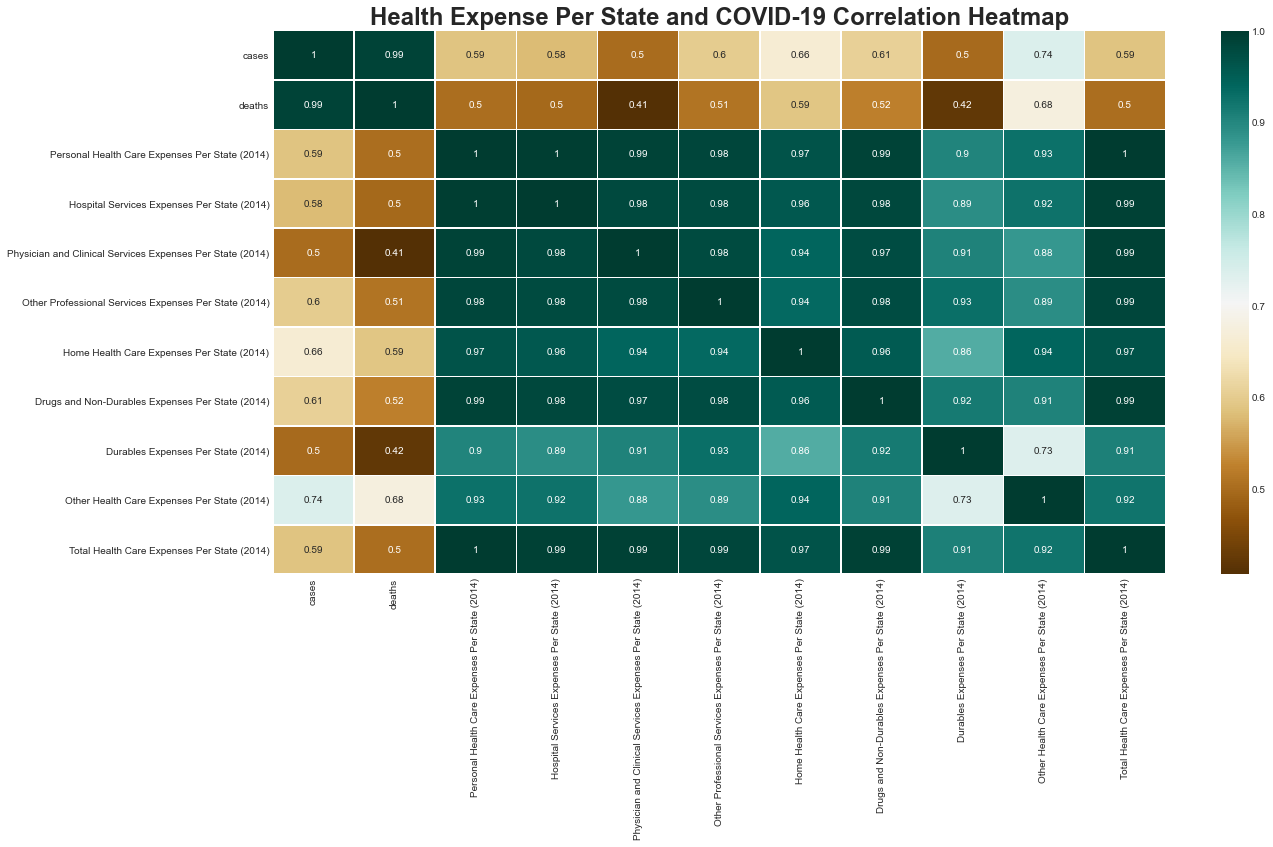

In [9]:
plt.figure(figsize = (20,10))
sns.heatmap(corr, cmap = 'BrBG', annot = True, linewidths = 0.5)
plt.title('Health Expense Per State and COVID-19 Correlation Heatmap', fontweight = 'bold', fontsize = 24);

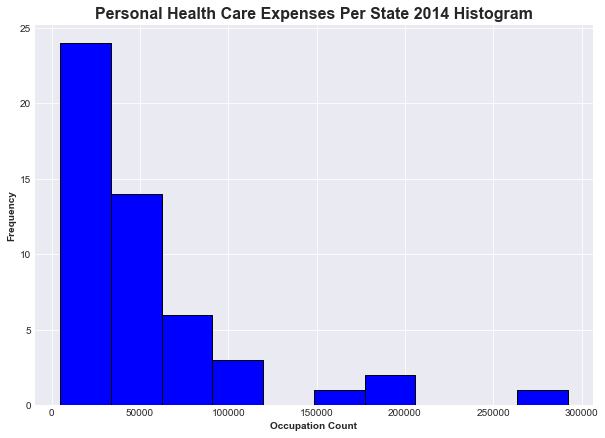

In [10]:
HPSDF['Personal Health Care Expenses Per State (2014)'].plot(kind = 'hist', color = 'blue', edgecolor = 'black', figsize = (10,7))
plt.title('Personal Health Care Expenses Per State 2014 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

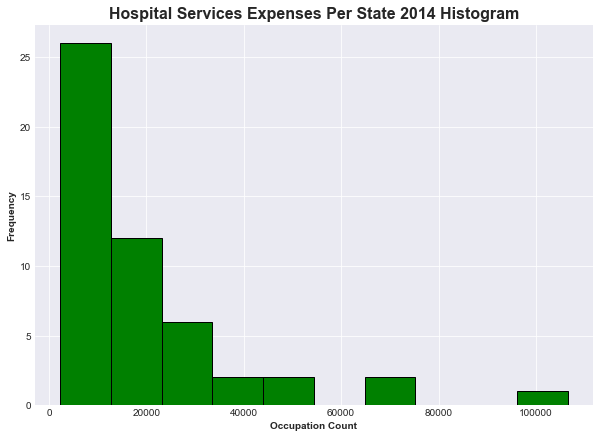

In [11]:
HPSDF['Hospital Services Expenses Per State (2014)'].plot(kind = 'hist', color = 'green', edgecolor = 'black', figsize = (10,7))
plt.title('Hospital Services Expenses Per State 2014 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

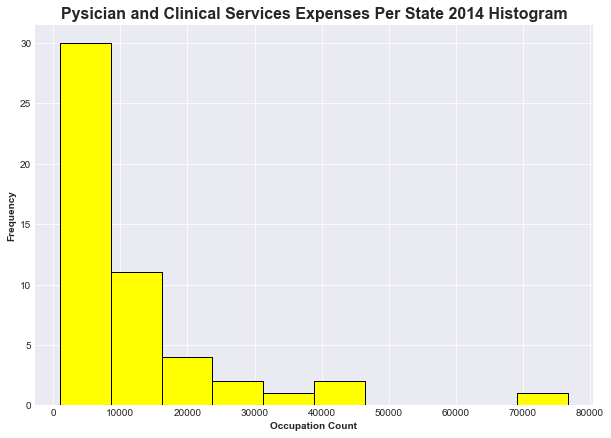

In [12]:
HPSDF['Physician and Clinical Services Expenses Per State (2014)'].plot(kind = 'hist', color = 'yellow', edgecolor = 'black', figsize = (10,7))
plt.title('Pysician and Clinical Services Expenses Per State 2014 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

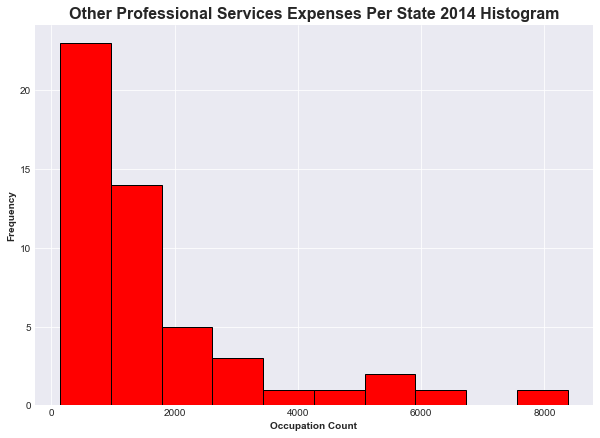

In [13]:
HPSDF['Other Professional Services Expenses Per State (2014)'].plot(kind = 'hist', color = 'red', edgecolor = 'black', figsize = (10,7))
plt.title('Other Professional Services Expenses Per State 2014 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

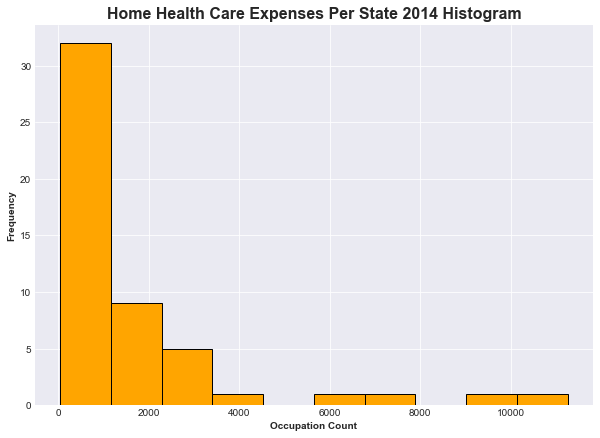

In [14]:
HPSDF['Home Health Care Expenses Per State (2014)'].plot(kind = 'hist', color = 'orange', edgecolor = 'black', figsize = (10,7))
plt.title('Home Health Care Expenses Per State 2014 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

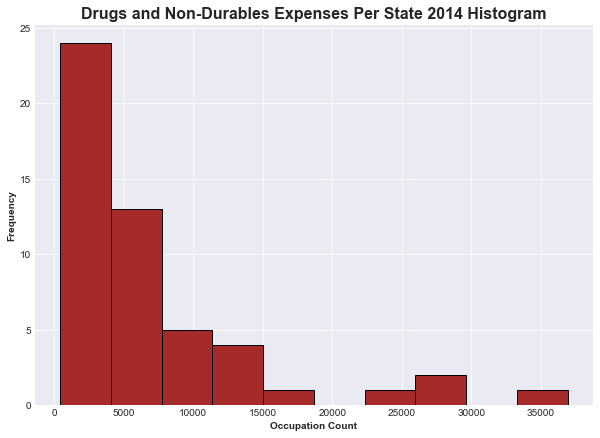

In [15]:
HPSDF['Drugs and Non-Durables Expenses Per State (2014)'].plot(kind = 'hist', color = 'brown', edgecolor = 'black', figsize = (10,7))
plt.title('Drugs and Non-Durables Expenses Per State 2014 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

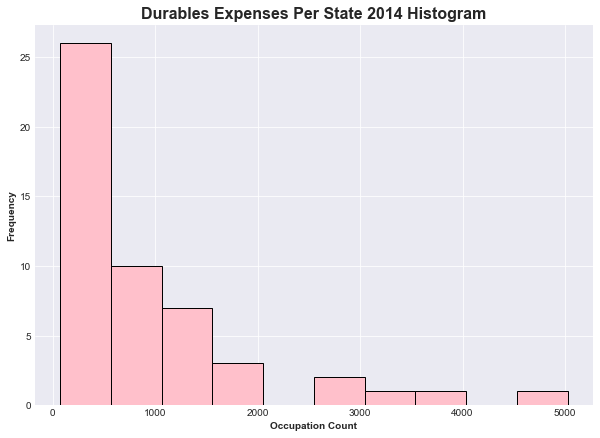

In [16]:
HPSDF['Durables Expenses Per State (2014)'].plot(kind = 'hist', color = 'pink', edgecolor = 'black', figsize = (10,7))
plt.title('Durables Expenses Per State 2014 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

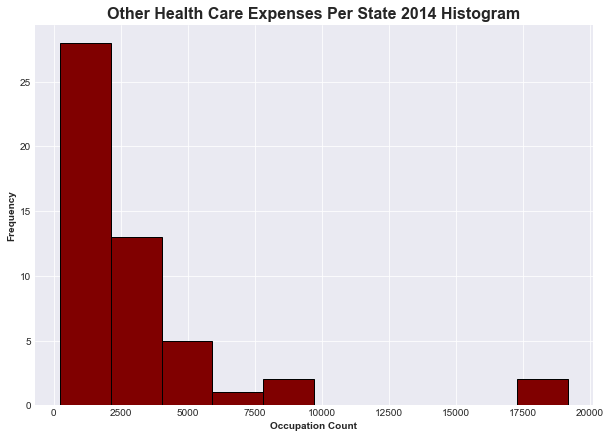

In [17]:
HPSDF['Other Health Care Expenses Per State (2014)'].plot(kind = 'hist', color = 'maroon', edgecolor = 'black', figsize = (10,7))
plt.title('Other Health Care Expenses Per State 2014 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

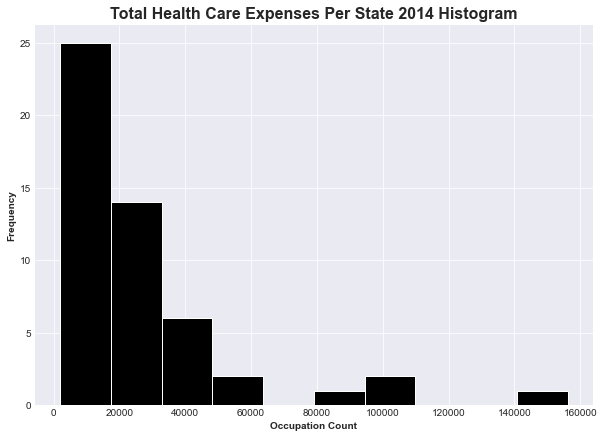

In [18]:
HPSDF['Total Health Care Expenses Per State (2014)'].plot(kind = 'hist', color = 'black', edgecolor = 'white', figsize = (10,7))
plt.title('Total Health Care Expenses Per State 2014 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

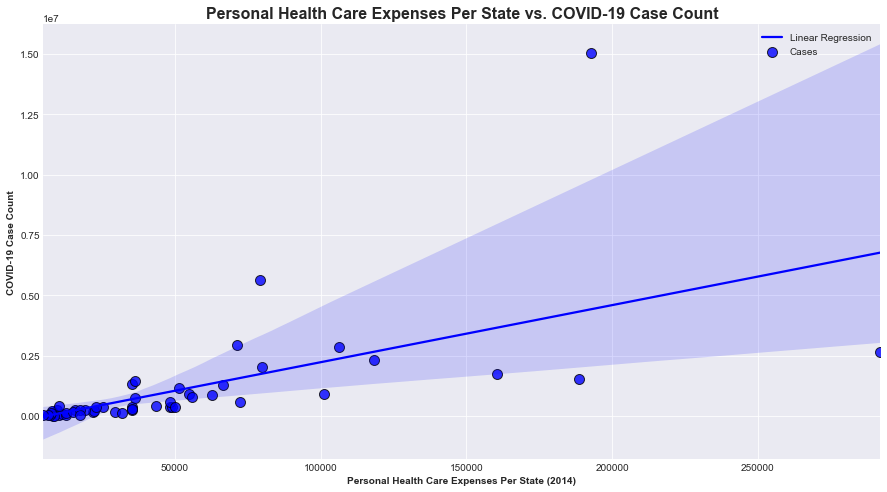

In [19]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Personal Health Care Expenses Per State (2014)', y = 'cases', data = HPSDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Personal Health Care Expenses Per State vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Personal Health Care Expenses Per State (2014)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [20]:
model1 = sm.OLS(HPSDF['cases'], HPSDF['Personal Health Care Expenses Per State (2014)']).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.464
Model:                            OLS   Adj. R-squared (uncentered):              0.453
Method:                 Least Squares   F-statistic:                              43.30
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    2.72e-08
Time:                        12:27:31   Log-Likelihood:                         -807.06
No. Observations:                  51   AIC:                                      1616.
Df Residuals:                      50   BIC:                                      1618.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Personal Health Care Expenses Per State (2014)    22.4599      3.413      6.581      0.000      15.605      29.315
==============================================================================
Omnibus:                       79.948   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1275.270
Skew:                           4.131   Prob(JB):                    1.20e-277
Kurtosis:                      26.062   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

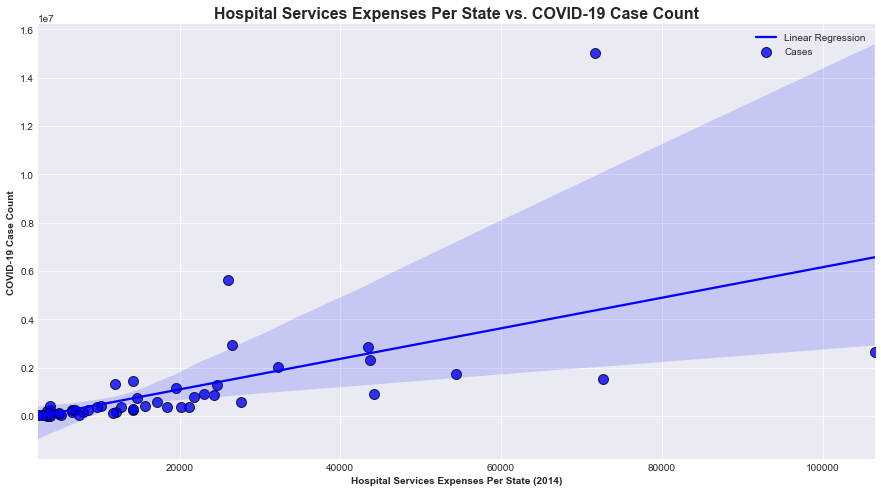

In [21]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Hospital Services Expenses Per State (2014)', y = 'cases', data = HPSDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Hospital Services Expenses Per State vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Hospital Services Expenses Per State (2014)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [22]:
model2 = sm.OLS(HPSDF['cases'], HPSDF['Hospital Services Expenses Per State (2014)']).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.456
Model:                            OLS   Adj. R-squared (uncentered):              0.445
Method:                 Least Squares   F-statistic:                              41.86
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    4.05e-08
Time:                        12:27:31   Log-Likelihood:                         -807.46
No. Observations:                  51   AIC:                                      1617.
Df Residuals:                      50   BIC:                                      1619.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Hospital Services Expenses Per State (2014)    59.3098      9.167      6.470      0.000      40.897      77.723
==============================================================================
Omnibus:                       80.935   Durbin-Watson:                   2.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1293.381
Skew:                           4.219   Prob(JB):                    1.40e-281
Kurtosis:                      26.183   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

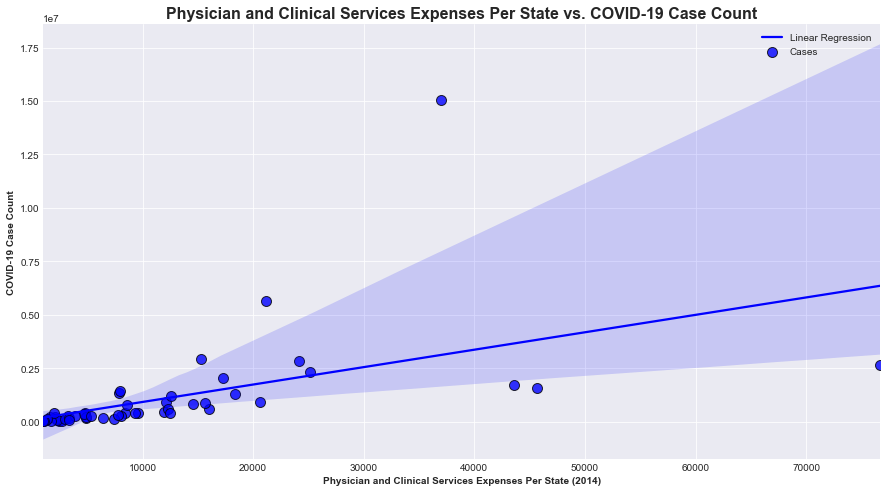

In [23]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Physician and Clinical Services Expenses Per State (2014)', y = 'cases', data = HPSDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Physician and Clinical Services Expenses Per State vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Physician and Clinical Services Expenses Per State (2014)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [24]:
model3 = sm.OLS(HPSDF['cases'], HPSDF['Physician and Clinical Services Expenses Per State (2014)']).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.388
Model:                            OLS   Adj. R-squared (uncentered):              0.376
Method:                 Least Squares   F-statistic:                              31.67
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    8.25e-07
Time:                        12:27:32   Log-Likelihood:                         -810.45
No. Observations:                  51   AIC:                                      1623.
Df Residuals:                      50   BIC:                                      1625.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Physician and Clinical Services Expenses Per State (2014)    85.2145     15.142      5.628      0.000      54.801     115.628
==============================================================================
Omnibus:                       84.743   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1559.281
Skew:                           4.463   Prob(JB):                         0.00
Kurtosis:                      28.575   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

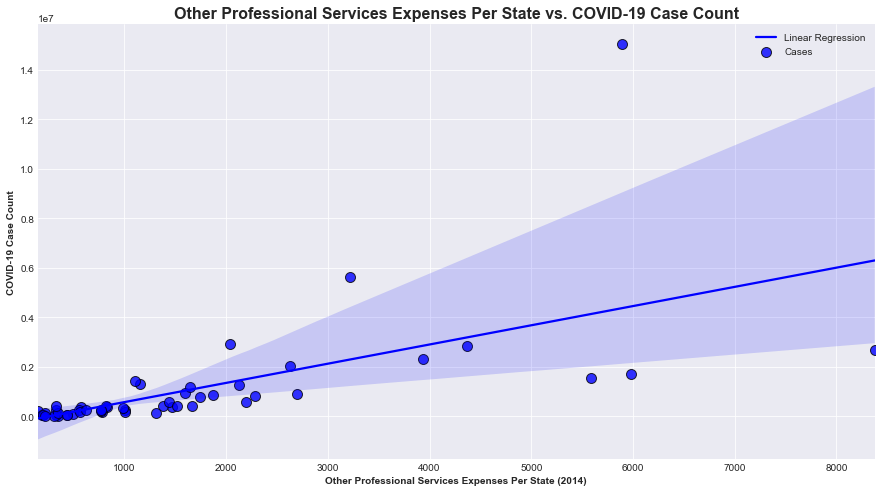

In [25]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Other Professional Services Expenses Per State (2014)', y = 'cases', data = HPSDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Other Professional Services Expenses Per State vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Other Professional Services Expenses Per State (2014)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [26]:
model4 = sm.OLS(HPSDF['cases'], HPSDF['Other Professional Services Expenses Per State (2014)']).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.475
Model:                            OLS   Adj. R-squared (uncentered):              0.464
Method:                 Least Squares   F-statistic:                              45.18
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    1.64e-08
Time:                        12:27:32   Log-Likelihood:                         -806.55
No. Observations:                  51   AIC:                                      1615.
Df Residuals:                      50   BIC:                                      1617.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Other Professional Services Expenses Per State (2014)   717.1935    106.697      6.722      0.000     502.886     931.501
==============================================================================
Omnibus:                       84.362   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1523.763
Skew:                           4.442   Prob(JB):                         0.00
Kurtosis:                      28.261   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

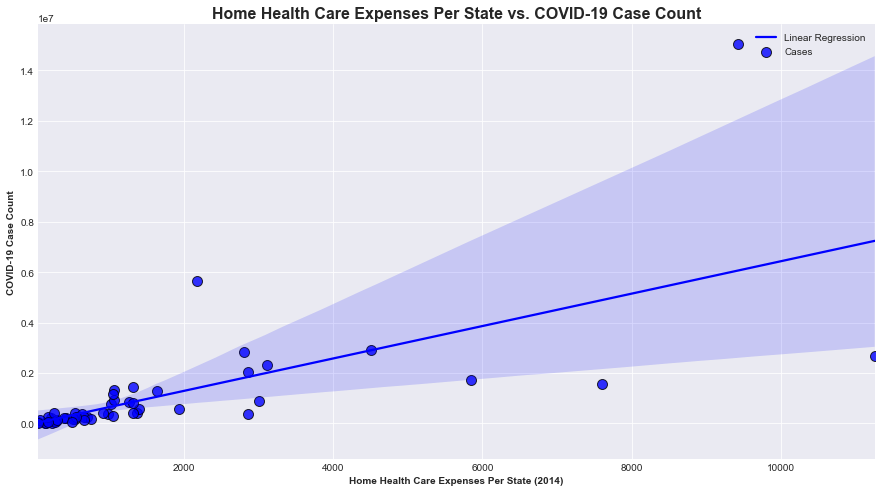

In [27]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Home Health Care Expenses Per State (2014)', y = 'cases', data = HPSDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Home Health Care Expenses Per State vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Home Health Care Expenses Per State (2014)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [28]:
model5 = sm.OLS(HPSDF['cases'], HPSDF['Home Health Care Expenses Per State (2014)']).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.541
Model:                            OLS   Adj. R-squared (uncentered):              0.532
Method:                 Least Squares   F-statistic:                              59.01
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    5.18e-10
Time:                        12:27:33   Log-Likelihood:                         -803.09
No. Observations:                  51   AIC:                                      1608.
Df Residuals:                      50   BIC:                                      1610.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Home Health Care Expenses Per State (2014)   643.7692     83.807      7.682      0.000     475.438     812.101
==============================================================================
Omnibus:                       59.089   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              586.280
Skew:                           2.754   Prob(JB):                    4.91e-128
Kurtosis:                      18.670   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

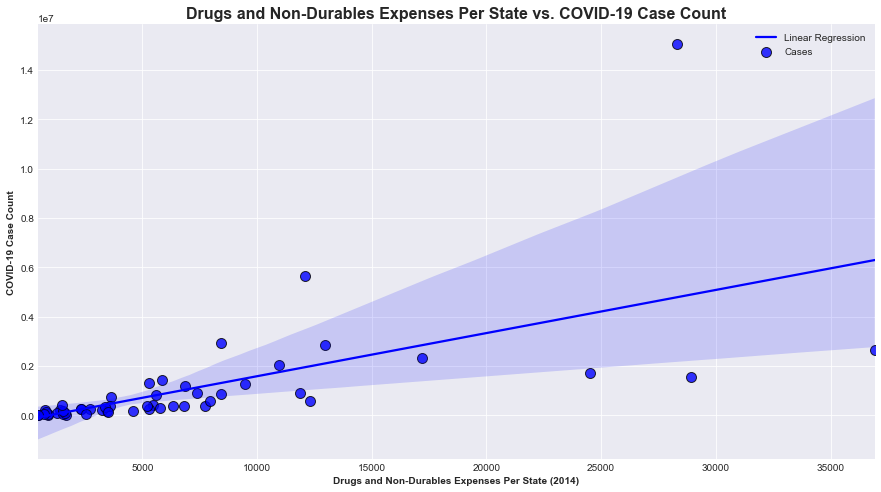

In [29]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Drugs and Non-Durables Expenses Per State (2014)', y = 'cases', data = HPSDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Drugs and Non-Durables Expenses Per State vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Drugs and Non-Durables Expenses Per State (2014)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [30]:
model6 = sm.OLS(HPSDF['cases'], HPSDF['Drugs and Non-Durables Expenses Per State (2014)']).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.482
Model:                            OLS   Adj. R-squared (uncentered):              0.472
Method:                 Least Squares   F-statistic:                              46.51
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    1.15e-08
Time:                        12:27:33   Log-Likelihood:                         -806.20
No. Observations:                  51   AIC:                                      1614.
Df Residuals:                      50   BIC:                                      1616.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Drugs and Non-Durables Expenses Per State (2014)   164.5419     24.127      6.820      0.000     116.082     213.002
==============================================================================
Omnibus:                       77.421   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1146.900
Skew:                           3.960   Prob(JB):                    8.99e-250
Kurtosis:                      24.840   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

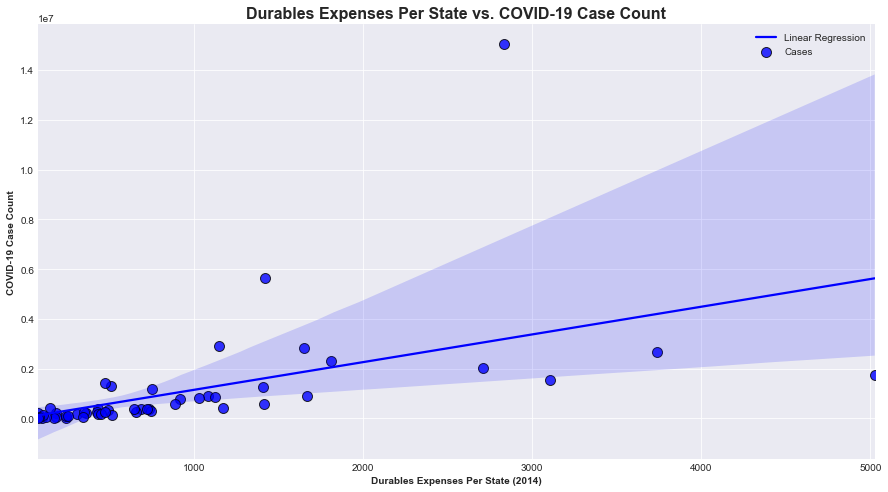

In [31]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Durables Expenses Per State (2014)', y = 'cases', data = HPSDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Durables Expenses Per State vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Durables Expenses Per State (2014)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [32]:
model7 = sm.OLS(HPSDF['cases'], HPSDF['Durables Expenses Per State (2014)']).fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.386
Model:                            OLS   Adj. R-squared (uncentered):              0.373
Method:                 Least Squares   F-statistic:                              31.37
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    9.07e-07
Time:                        12:27:33   Log-Likelihood:                         -810.55
No. Observations:                  51   AIC:                                      1623.
Df Residuals:                      50   BIC:                                      1625.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Durables Expenses Per State (2014)  1132.5519    202.216      5.601      0.000     726.389    1538.715
==============================================================================
Omnibus:                       84.424   Durbin-Watson:                   2.159
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1513.437
Skew:                           4.454   Prob(JB):                         0.00
Kurtosis:                      28.157   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

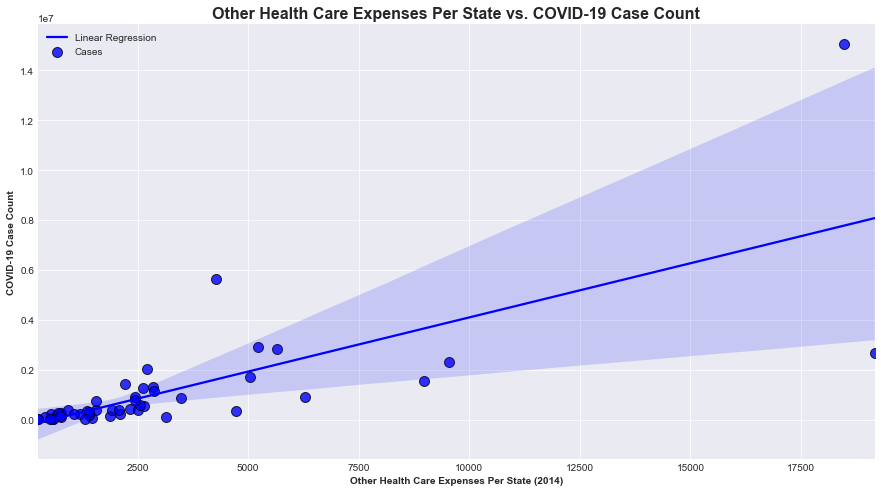

In [33]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Other Health Care Expenses Per State (2014)', y = 'cases', data = HPSDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Other Health Care Expenses Per State vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Other Health Care Expenses Per State (2014)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [34]:
model8 = sm.OLS(HPSDF['cases'], HPSDF['Other Health Care Expenses Per State (2014)']).fit()
model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.620
Model:                            OLS   Adj. R-squared (uncentered):              0.613
Method:                 Least Squares   F-statistic:                              81.71
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    4.29e-12
Time:                        12:27:34   Log-Likelihood:                         -798.27
No. Observations:                  51   AIC:                                      1599.
Df Residuals:                      50   BIC:                                      1600.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Other Health Care Expenses Per State (2014)   403.9070     44.684      9.039      0.000     314.158     493.656
==============================================================================
Omnibus:                       50.739   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              444.423
Skew:                           2.237   Prob(JB):                     3.12e-97
Kurtosis:                      16.752   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

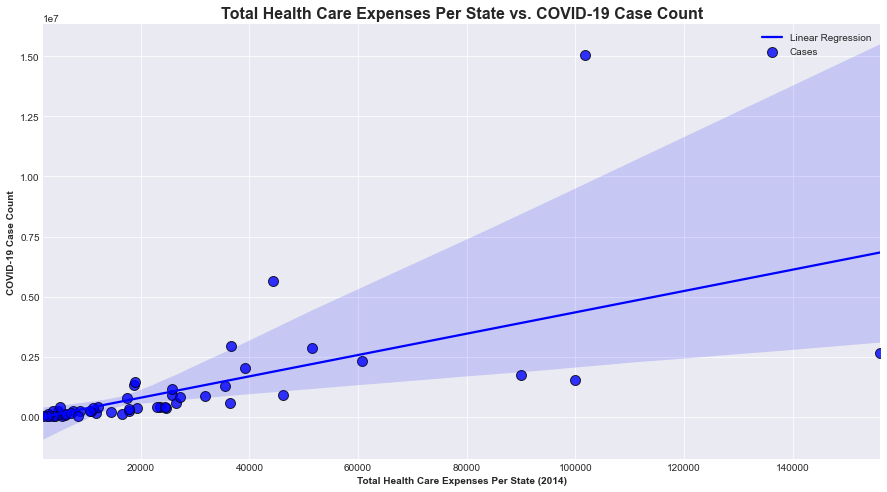

In [35]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Total Health Care Expenses Per State (2014)', y = 'cases', data = HPSDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Total Health Care Expenses Per State vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Total Health Care Expenses Per State (2014)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [36]:
model9 = sm.OLS(HPSDF['cases'], HPSDF['Total Health Care Expenses Per State (2014)']).fit()
model9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.466
Model:                            OLS   Adj. R-squared (uncentered):              0.455
Method:                 Least Squares   F-statistic:                              43.55
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    2.54e-08
Time:                        12:27:34   Log-Likelihood:                         -806.99
No. Observations:                  51   AIC:                                      1616.
Df Residuals:                      50   BIC:                                      1618.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Total Health Care Expenses Per State (2014)    42.8736      6.496      6.600      0.000      29.825      55.922
==============================================================================
Omnibus:                       78.522   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1227.319
Skew:                           4.018   Prob(JB):                    3.10e-267
Kurtosis:                      25.649   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
model10 = sm.OLS(HPSDF['cases'], HPSDF[['Personal Health Care Expenses Per State (2014)', 'Hospital Services Expenses Per State (2014)',
                                      'Physician and Clinical Services Expenses Per State (2014)', 'Other Professional Services Expenses Per State (2014)',
                                      'Home Health Care Expenses Per State (2014)', 'Drugs and Non-Durables Expenses Per State (2014)',
                                      'Durables Expenses Per State (2014)', 'Other Health Care Expenses Per State (2014)', 'Total Health Care Expenses Per State (2014)']]).fit()
model10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.862
Model:                            OLS   Adj. R-squared (uncentered):              0.836
Method:                 Least Squares   F-statistic:                              33.56
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    4.57e-16
Time:                        12:27:34   Log-Likelihood:                         -772.47
No. Observations:                  51   AIC:                                      1561.
Df Residuals:                      43   BIC:                                      1576.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Personal Health Care Expenses Per State (2014)             -111.5783    269.773     -0.414      0.681    -655.628     432.472
Hospital Services Expenses Per State (2014)                 -31.9044    302.012     -0.106      0.916    -640.970     577.161
Physician and Clinical Services Expenses Per State (2014)  -822.9003    105.866     -7.773      0.000   -1036.399    -609.402
Other Professional Services Expenses Per State (2014)      1823.6304    566.684      3.218      0.002     680.803    2966.458
Home Health Care Expenses Per State (2014)                   72.8961    291.833      0.250      0.804    -515.640     661.433
Drugs and Non-Durables Expenses Per State (2014)           -195.5029    162.890     -1.200      0.237    -524.001     132.995
Durables Expenses Per State (2014)                         -415.4230    560.602     -0.741      0.463   -1545.984     715.138
Other Health Care Expenses Per State (2014)                 127.3916    197.685      0.644      0.523    -271.278     526.061
Total Health Care Expenses Per State (2014)                 590.0919    298.729      1.975      0.055     -12.353    1192.537
==============================================================================
Omnibus:                        8.220   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               16.756
Skew:                           0.104   Prob(JB):                     0.000230
Kurtosis:                       5.800   Cond. No.                     2.87e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.19e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

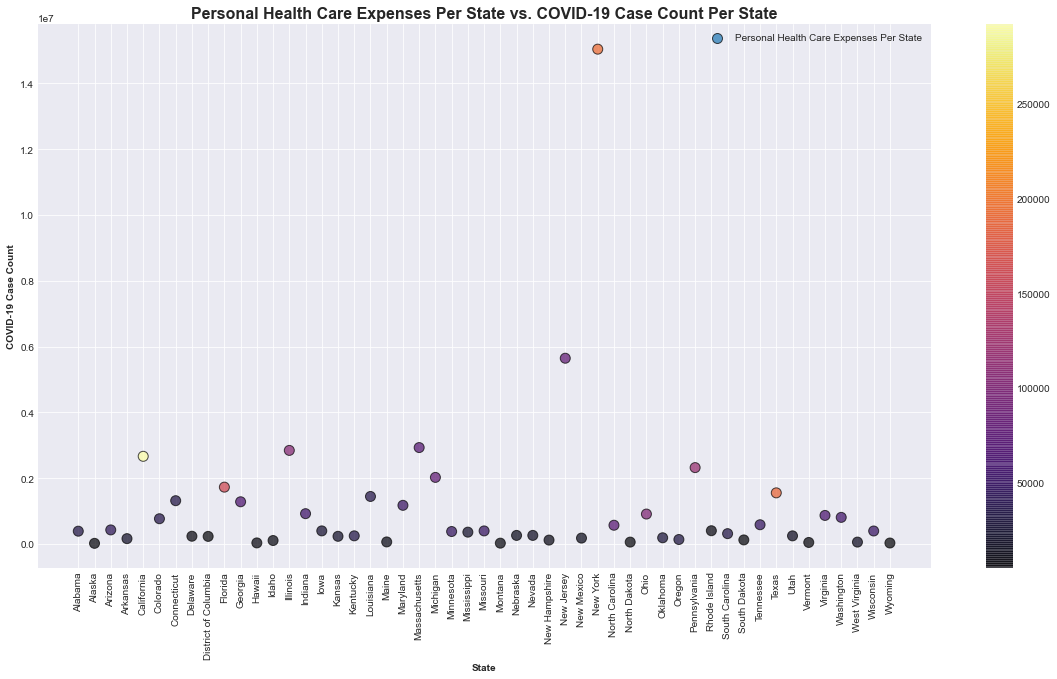

In [38]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = HPSDF['State'] 
y = HPSDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = HPSDF['Personal Health Care Expenses Per State (2014)'], cmap = 'inferno')
plt.title('Personal Health Care Expenses Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Personal Health Care Expenses Per State'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

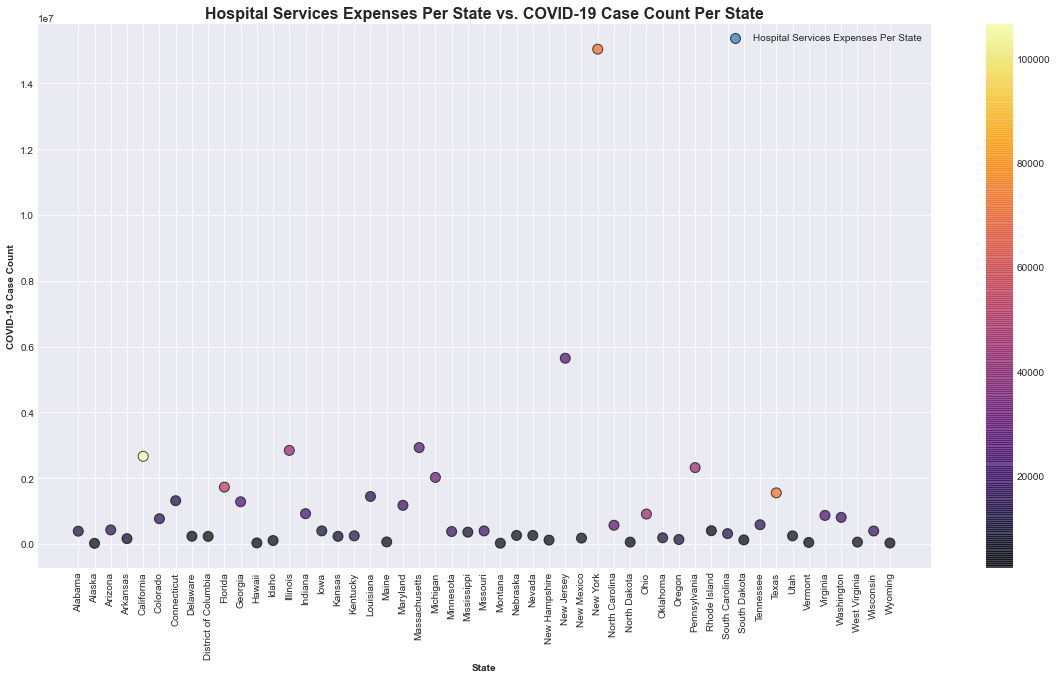

In [39]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = HPSDF['State'] 
y = HPSDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = HPSDF['Hospital Services Expenses Per State (2014)'], cmap = 'inferno')
plt.title('Hospital Services Expenses Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Hospital Services Expenses Per State'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

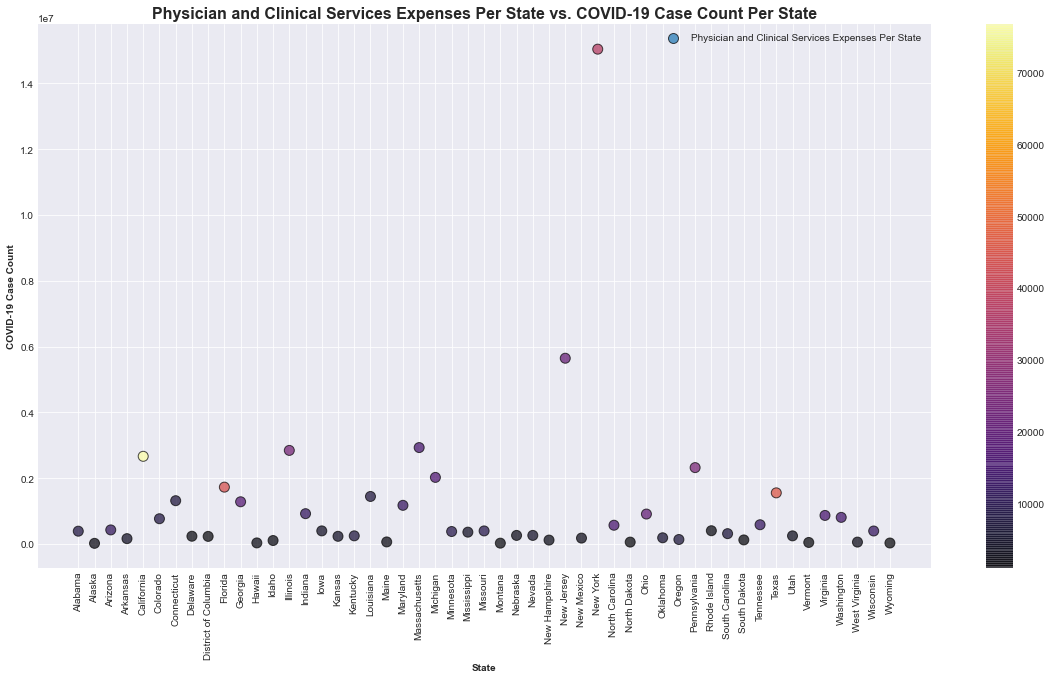

In [40]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = HPSDF['State'] 
y = HPSDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = HPSDF['Physician and Clinical Services Expenses Per State (2014)'], cmap = 'inferno')
plt.title('Physician and Clinical Services Expenses Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Physician and Clinical Services Expenses Per State'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

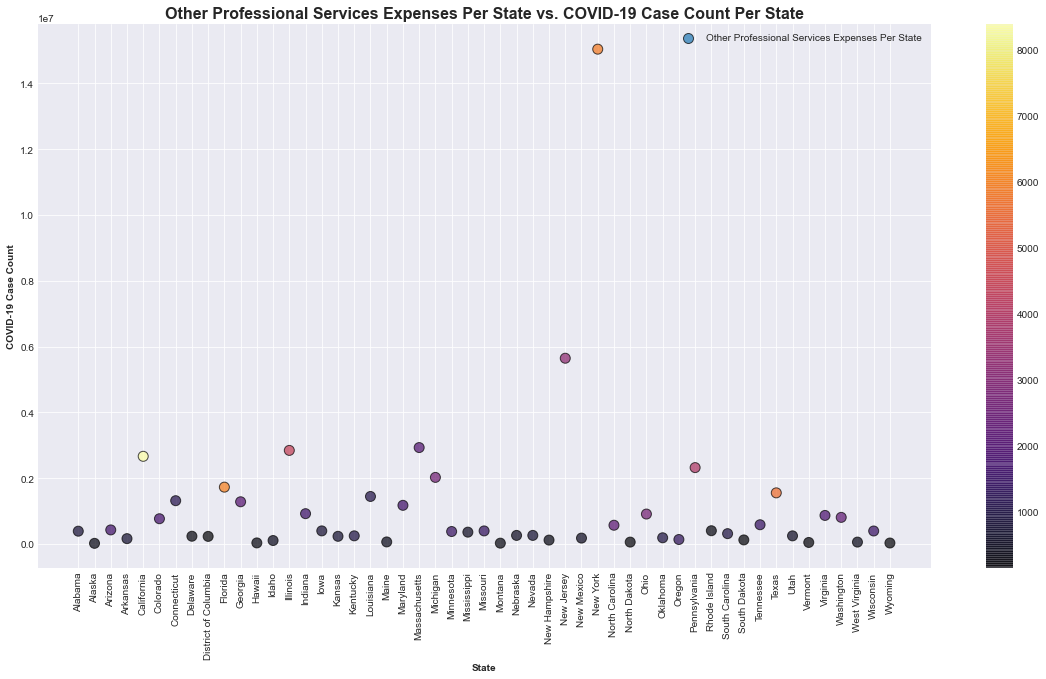

In [41]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = HPSDF['State'] 
y = HPSDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = HPSDF['Other Professional Services Expenses Per State (2014)'], cmap = 'inferno')
plt.title('Other Professional Services Expenses Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Other Professional Services Expenses Per State'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

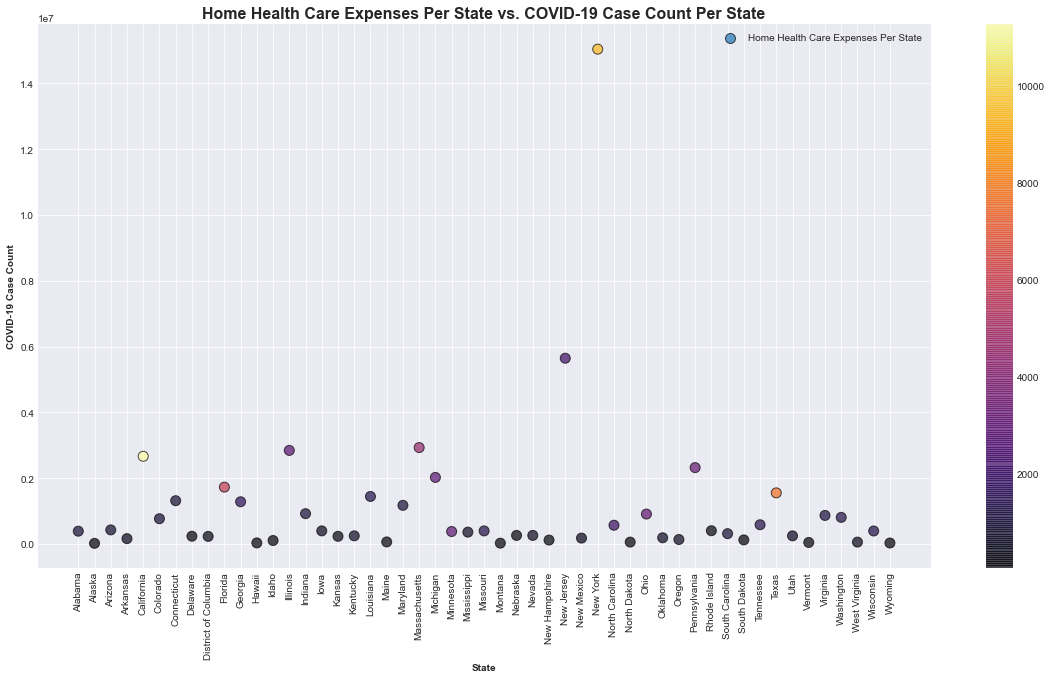

In [42]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = HPSDF['State'] 
y = HPSDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = HPSDF['Home Health Care Expenses Per State (2014)'], cmap = 'inferno')
plt.title('Home Health Care Expenses Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Home Health Care Expenses Per State'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

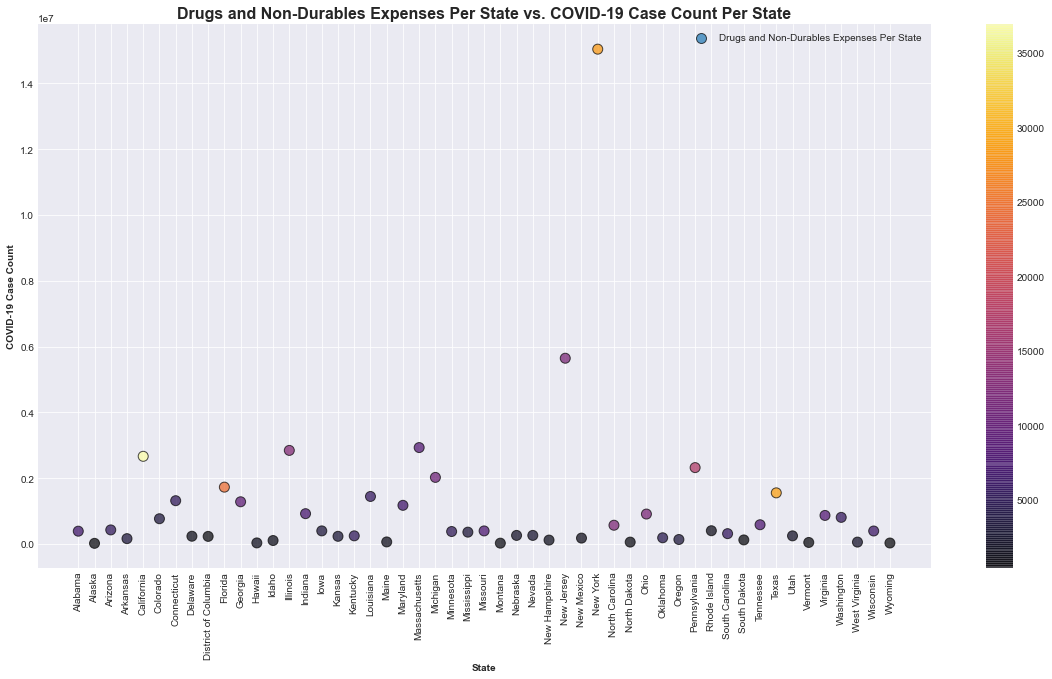

In [43]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = HPSDF['State'] 
y = HPSDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = HPSDF['Drugs and Non-Durables Expenses Per State (2014)'], cmap = 'inferno')
plt.title('Drugs and Non-Durables Expenses Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Drugs and Non-Durables Expenses Per State'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

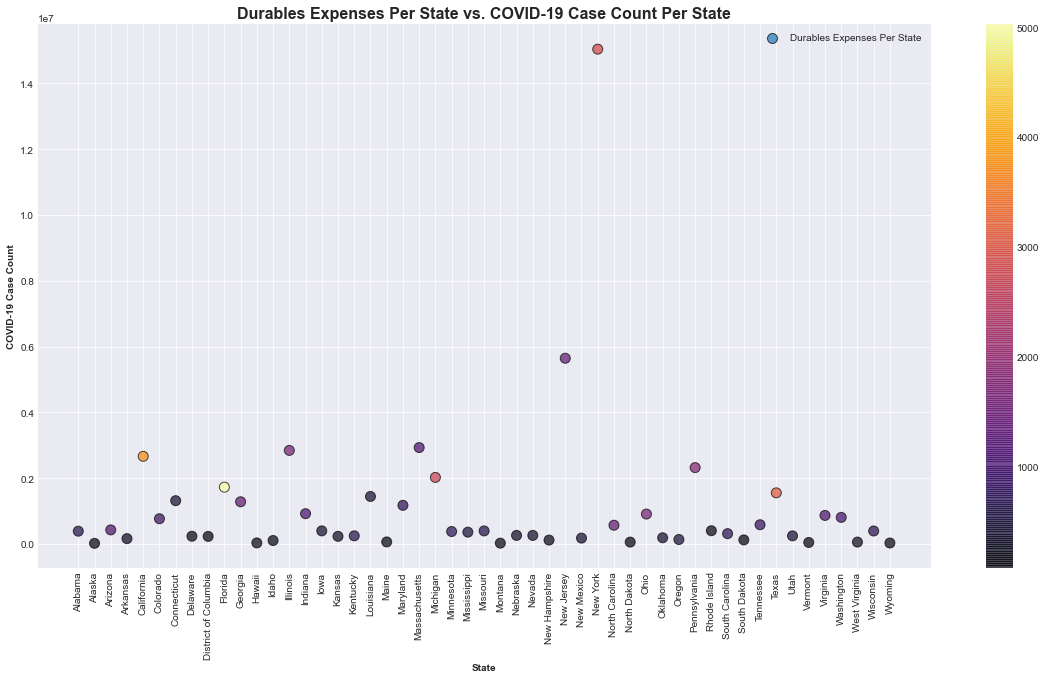

In [44]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = HPSDF['State'] 
y = HPSDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = HPSDF['Durables Expenses Per State (2014)'], cmap = 'inferno')
plt.title('Durables Expenses Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Durables Expenses Per State'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

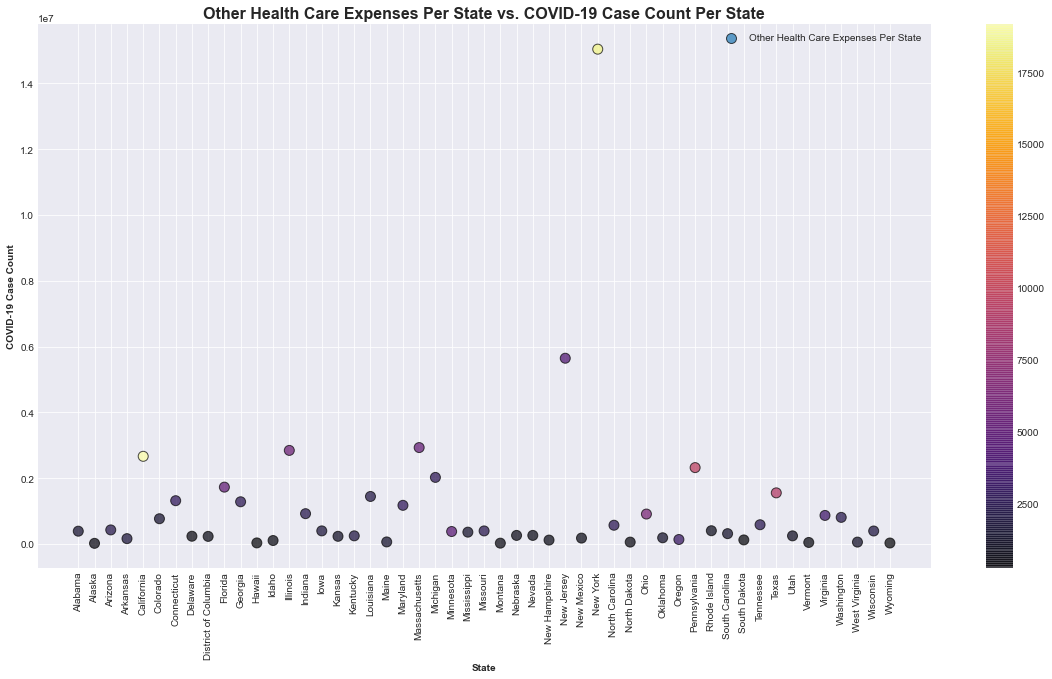

In [45]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = HPSDF['State'] 
y = HPSDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = HPSDF['Other Health Care Expenses Per State (2014)'], cmap = 'inferno')
plt.title('Other Health Care Expenses Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Other Health Care Expenses Per State'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

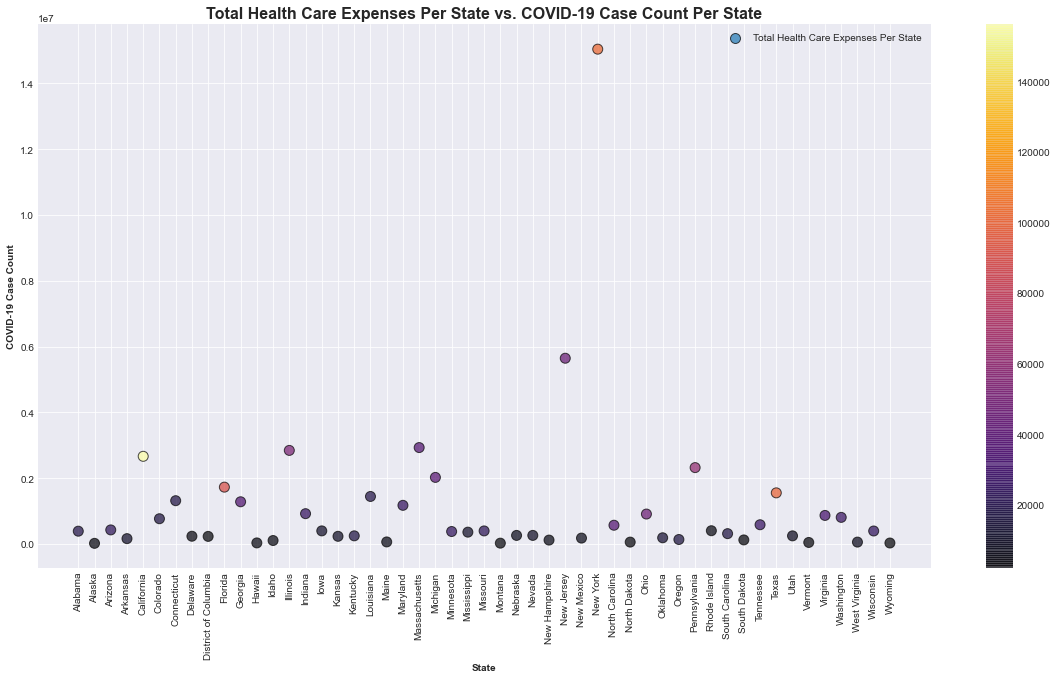

In [46]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = HPSDF['State'] 
y = HPSDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = HPSDF['Total Health Care Expenses Per State (2014)'], cmap = 'inferno')
plt.title('Total Health Care Expenses Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Total Health Care Expenses Per State'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

In [3]:
test_len = int(0.25 * len(HPSDF))
train_len = len(HPSDF) - test_len
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))

train = HPSDF[:train_len]
test = HPSDF[train_len:]
print('Train Set Shape: ' + str(train.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 39
Test Set Len: 12
Train Set Shape: (39, 12)
Test Set Shape: (12, 12)


In [4]:
features_list = ['Personal Health Care Expenses Per State (2014)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)



MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 950631988275.0834
MSE Value: 9.247047159092785e+23
RMS Value: 961615679941.461
R2 Score: -5029270569531.044


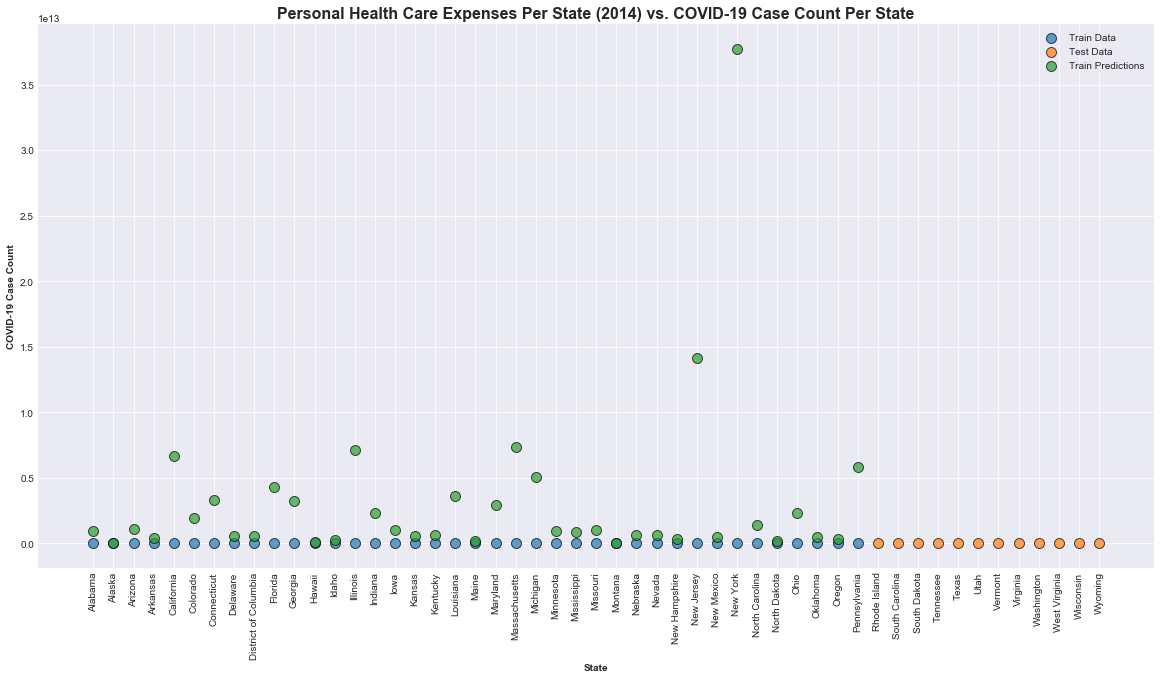

In [5]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Personal Health Care Expenses Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

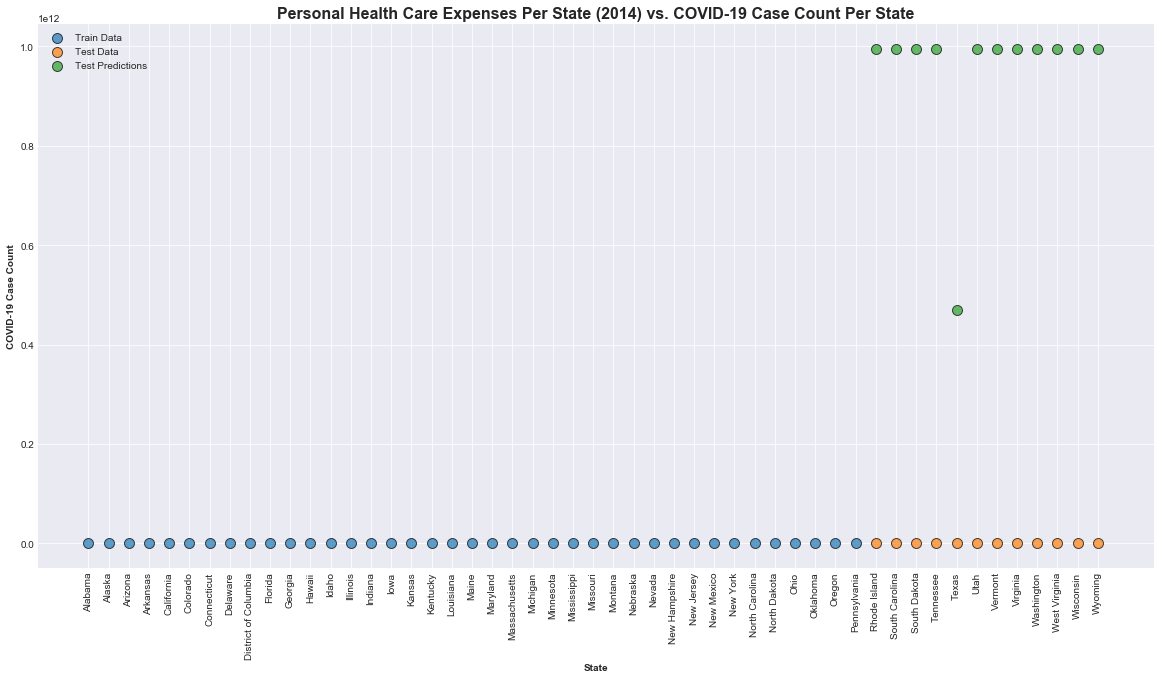

In [6]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Personal Health Care Expenses Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [7]:
features_list = ['Hospital Services Expenses Per State (2014)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)



MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 907281303261.75
MSE Value: 8.238281516182602e+23
RMS Value: 907649795691.1907
R2 Score: -4480624577771.984


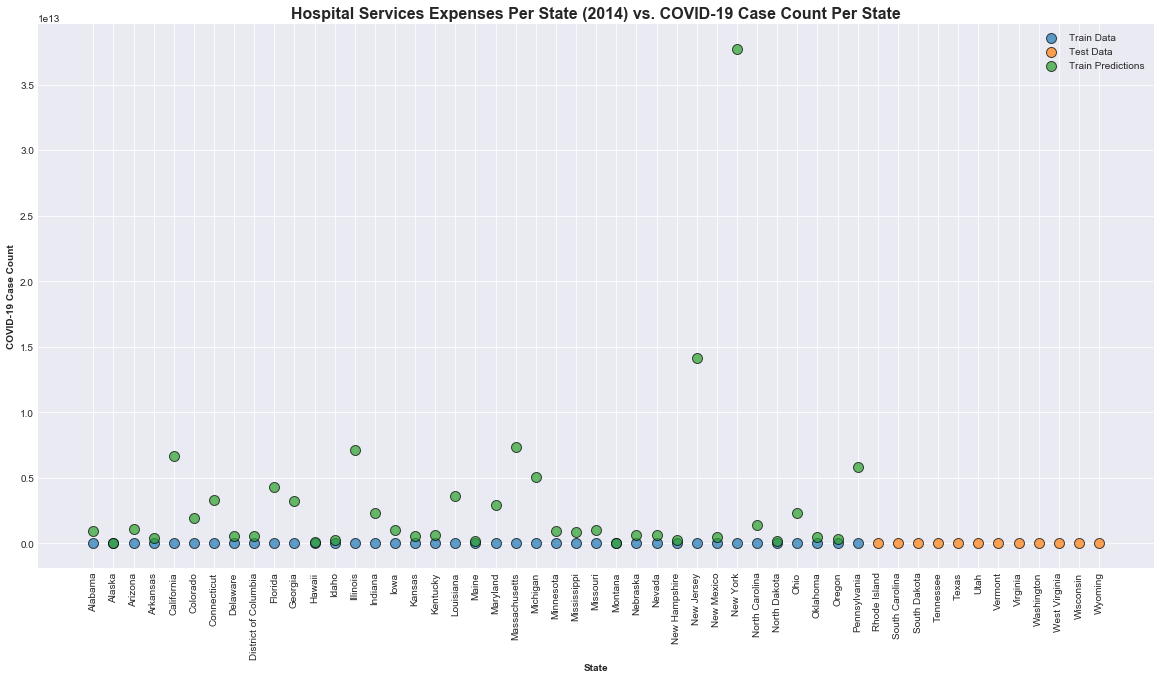

In [8]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Hospital Services Expenses Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

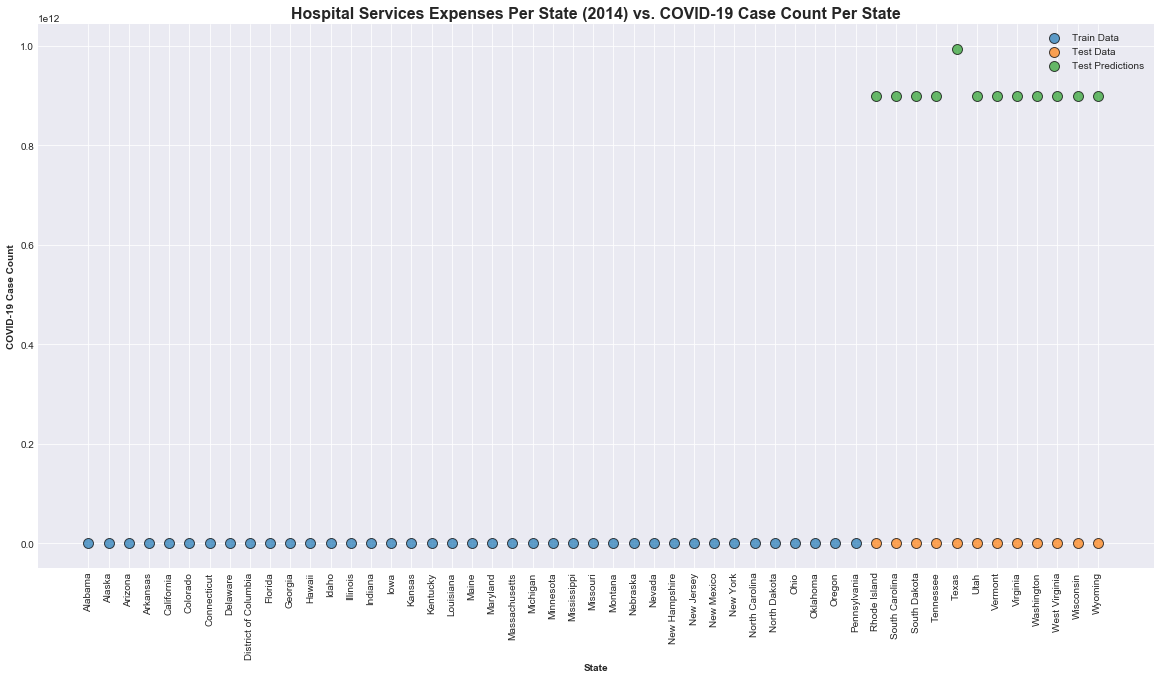

In [9]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Hospital Services Expenses Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [10]:
features_list = ['Physician and Clinical Services Expenses Per State (2014)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)


MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 650790247475.0834
MSE Value: 4.2352794620886415e+23
RMS Value: 650790247475.2246
R2 Score: -2303477638423.379


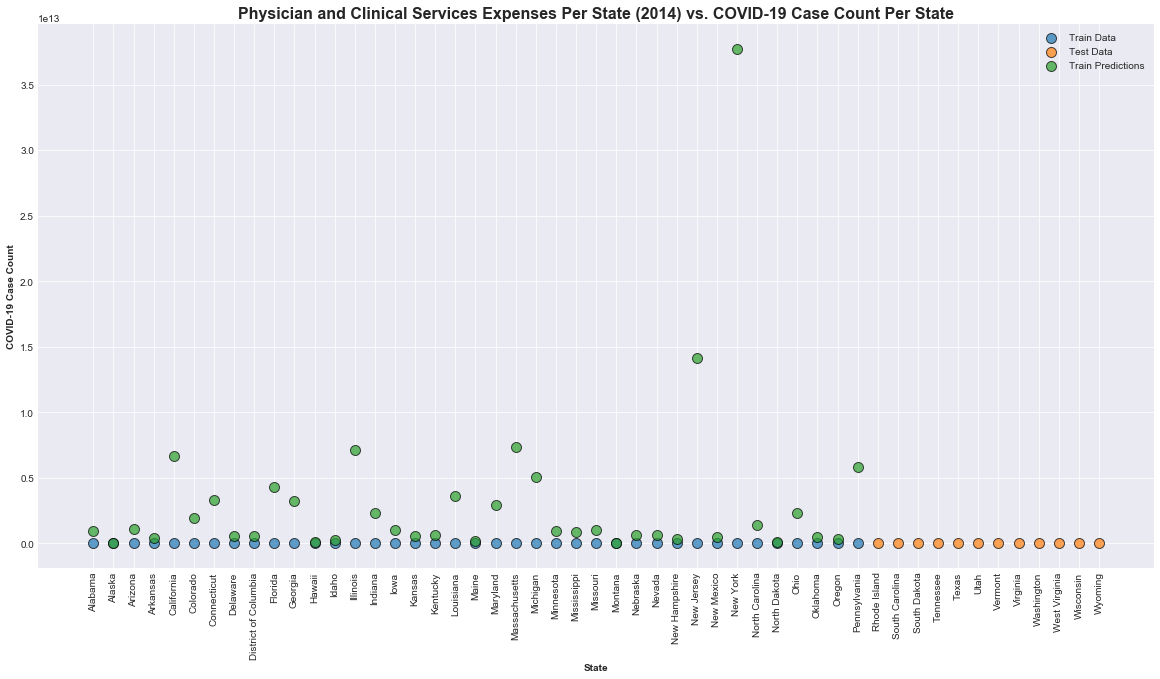

In [11]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Physician and Clinical Services Expenses Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

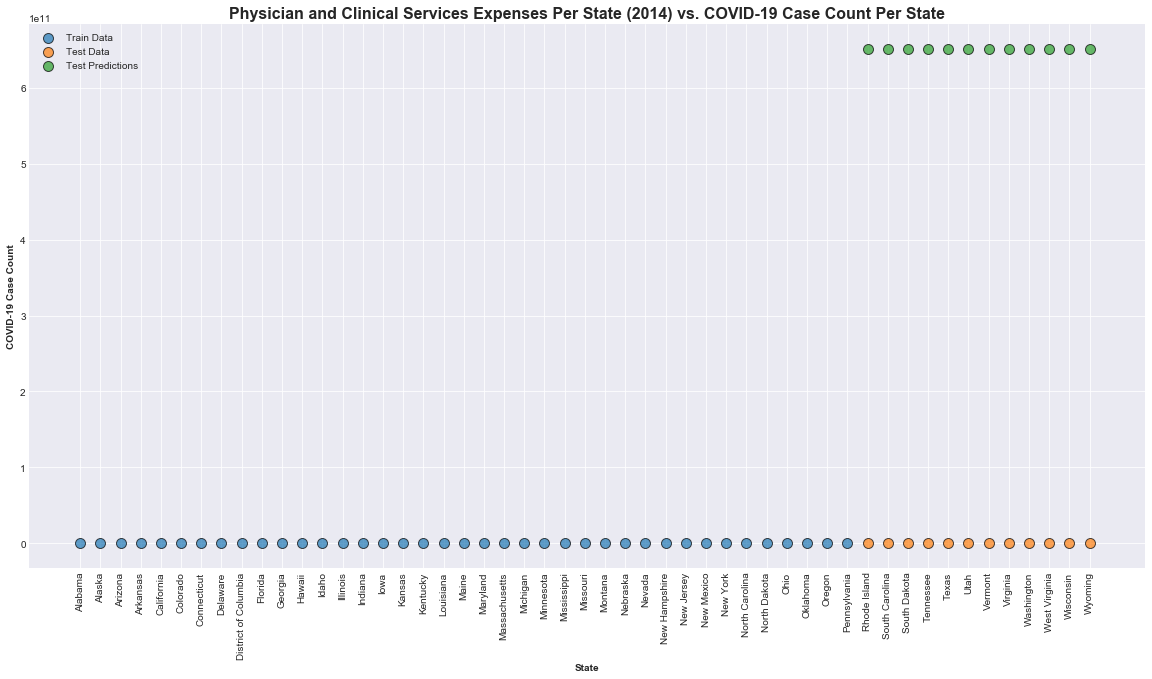

In [12]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Physician and Clinical Services Expenses Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [13]:
features_list = ['Other Professional Services Expenses Per State (2014)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)


MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 971949808691.0834
MSE Value: 9.446864306148172e+23
RMS Value: 971949808691.1779
R2 Score: -5137946829063.834


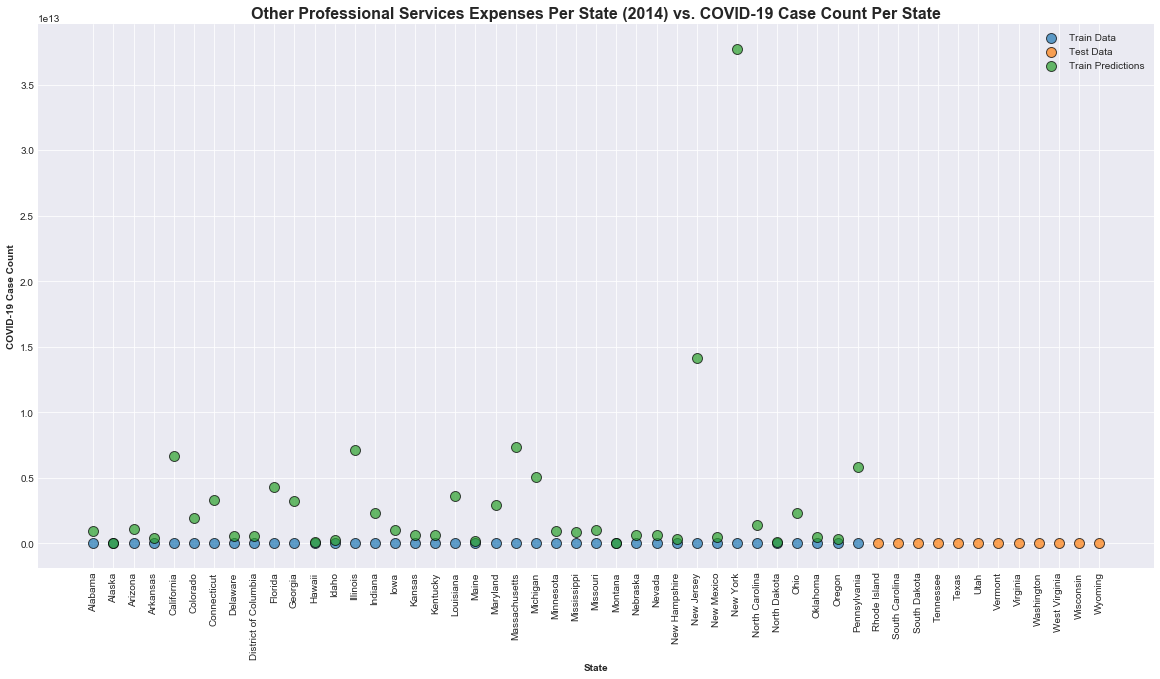

In [14]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Other Professional Services Expenses Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

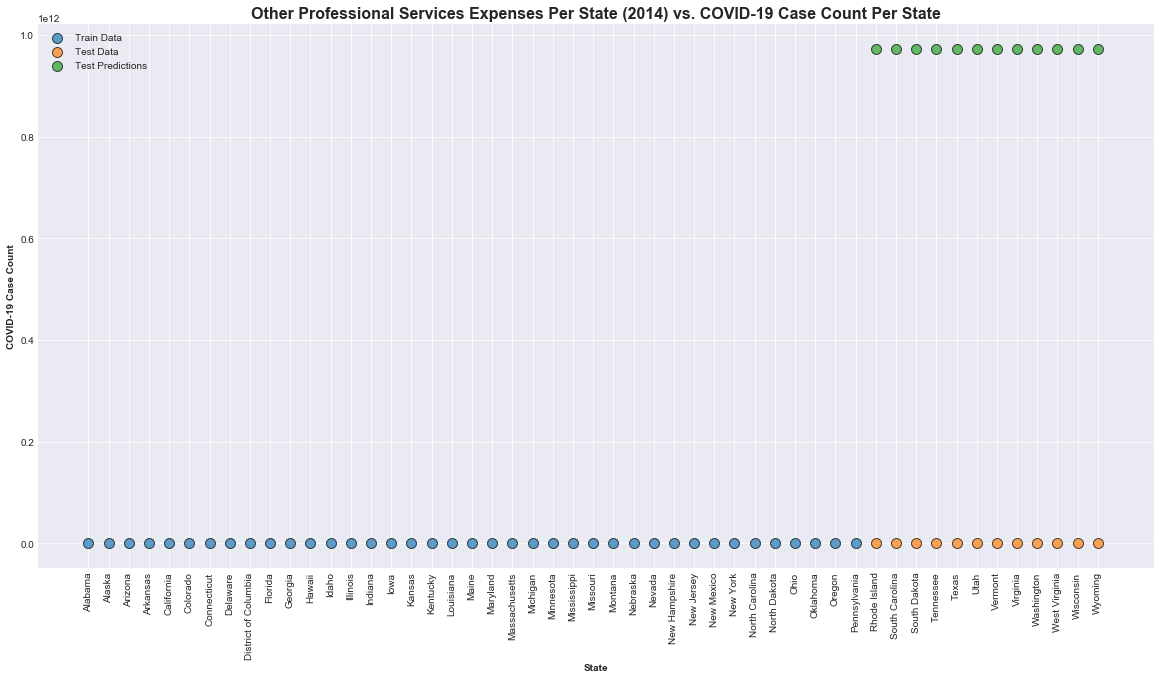

In [15]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Other Professional Services Expenses Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [16]:
features_list = ['Home Health Care Expenses Per State (2014)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)



MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 994738707507.0834
MSE Value: 9.895050962130464e+23
RMS Value: 994738707507.1757
R2 Score: -5381705936139.683


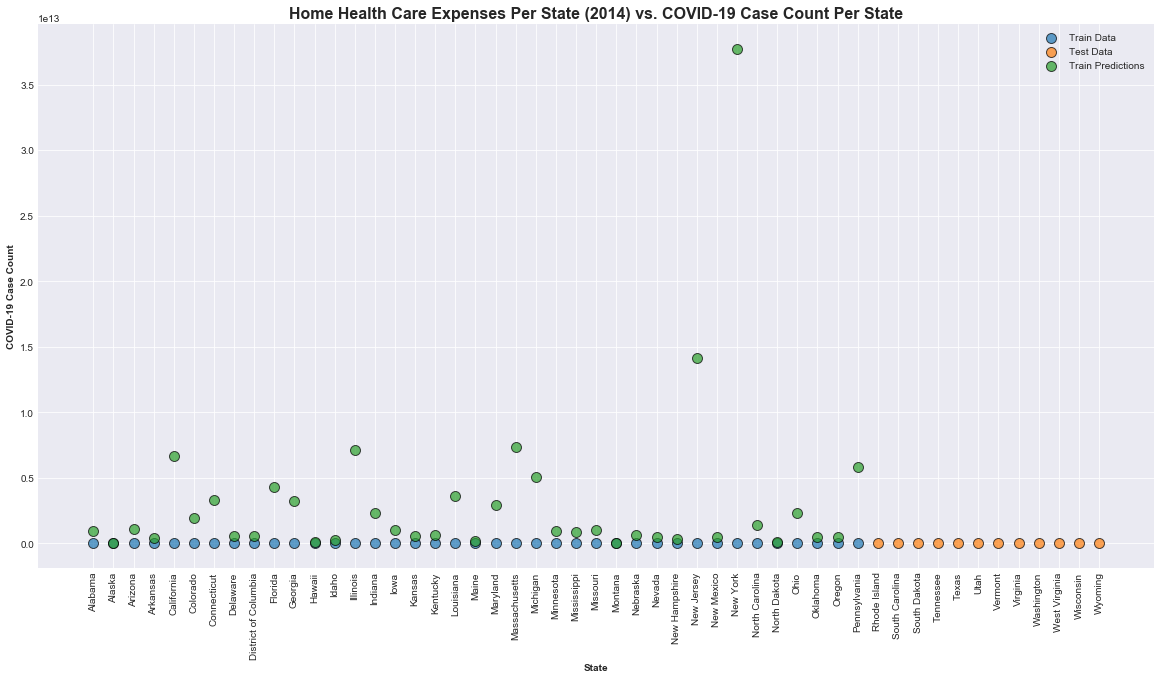

In [17]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Home Health Care Expenses Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

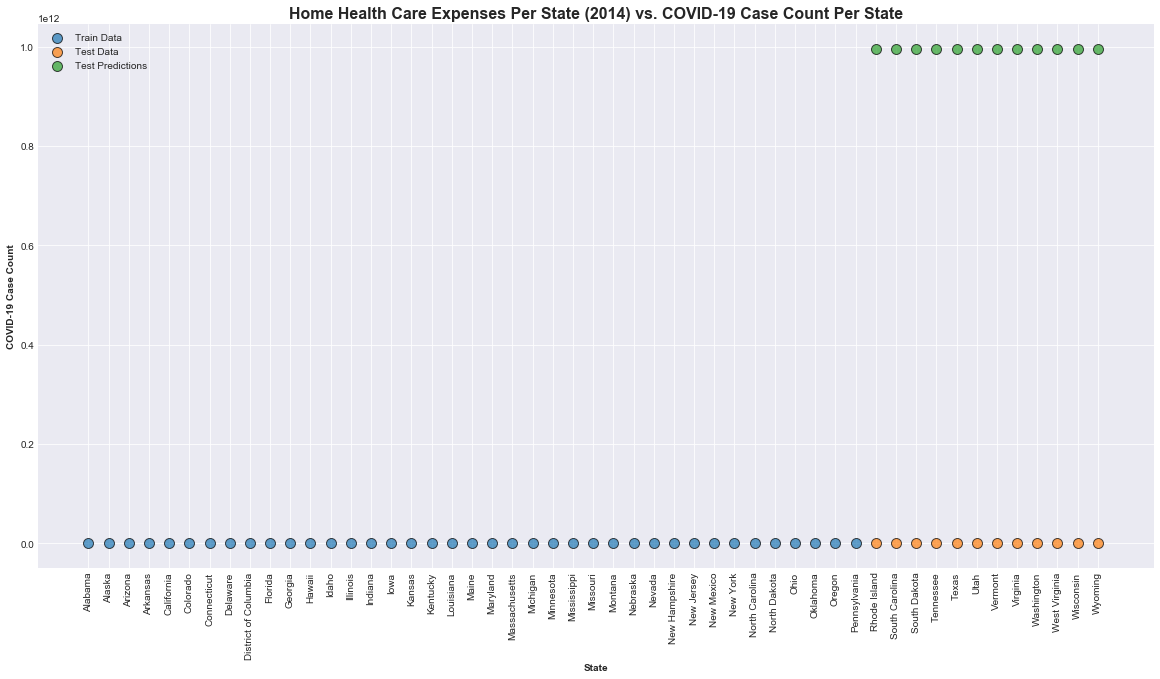

In [18]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Home Health Care Expenses Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [19]:
features_list = ['Drugs and Non-Durables Expenses Per State (2014)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)



MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 767455269256.4166
MSE Value: 6.382956510167624e+23
RMS Value: 798934071758.5916
R2 Score: -3471553109969.128


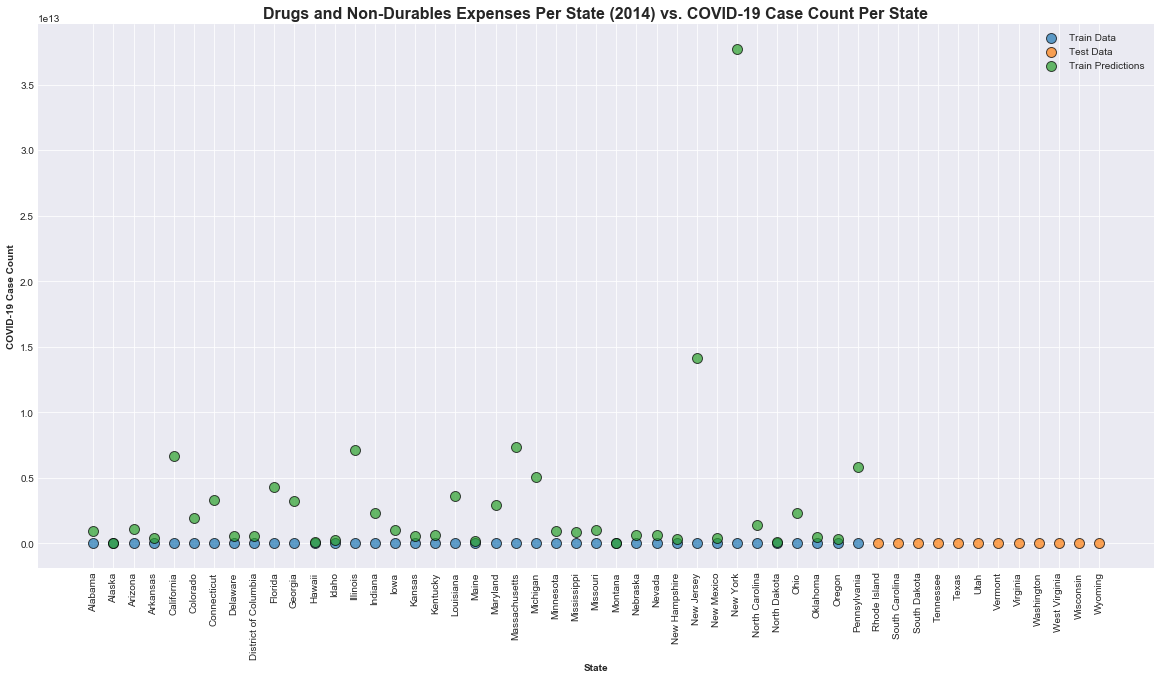

In [20]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Drugs and Non-Durables Expenses Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

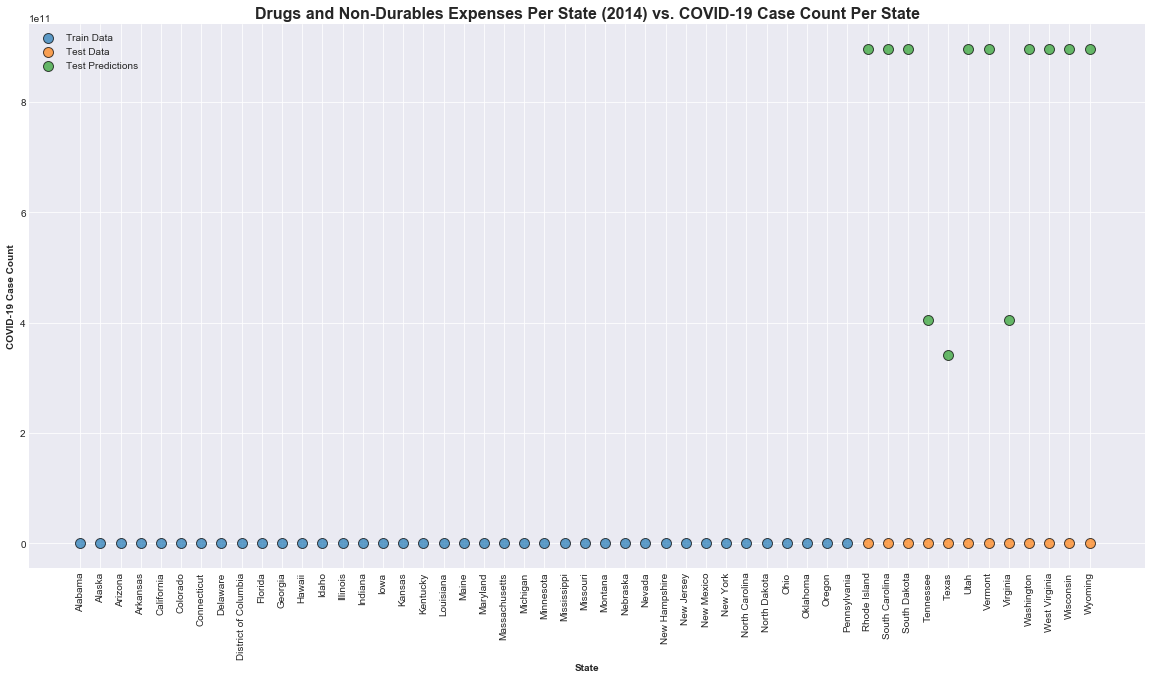

In [21]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Drugs and Non-Durables Expenses Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [22]:
features_list = ['Durables Expenses Per State (2014)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)


MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 471204371507.0833
MSE Value: 2.220335597275693e+23
RMS Value: 471204371507.27844
R2 Score: -1207592897682.3013


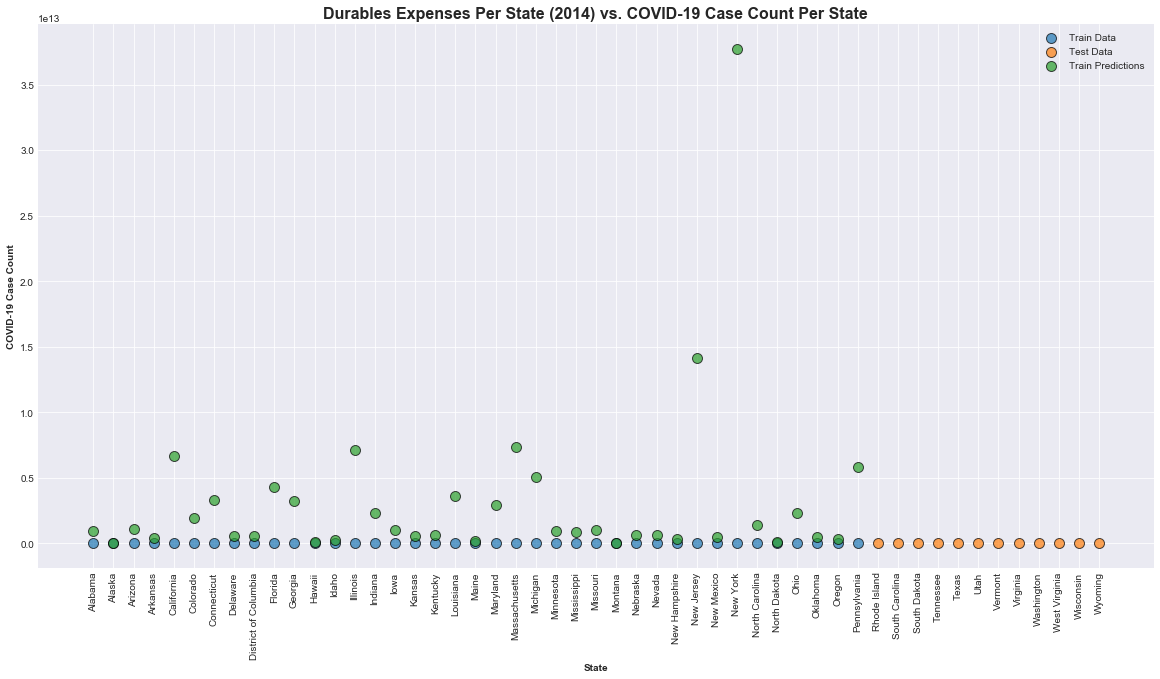

In [23]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Durables Expenses Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

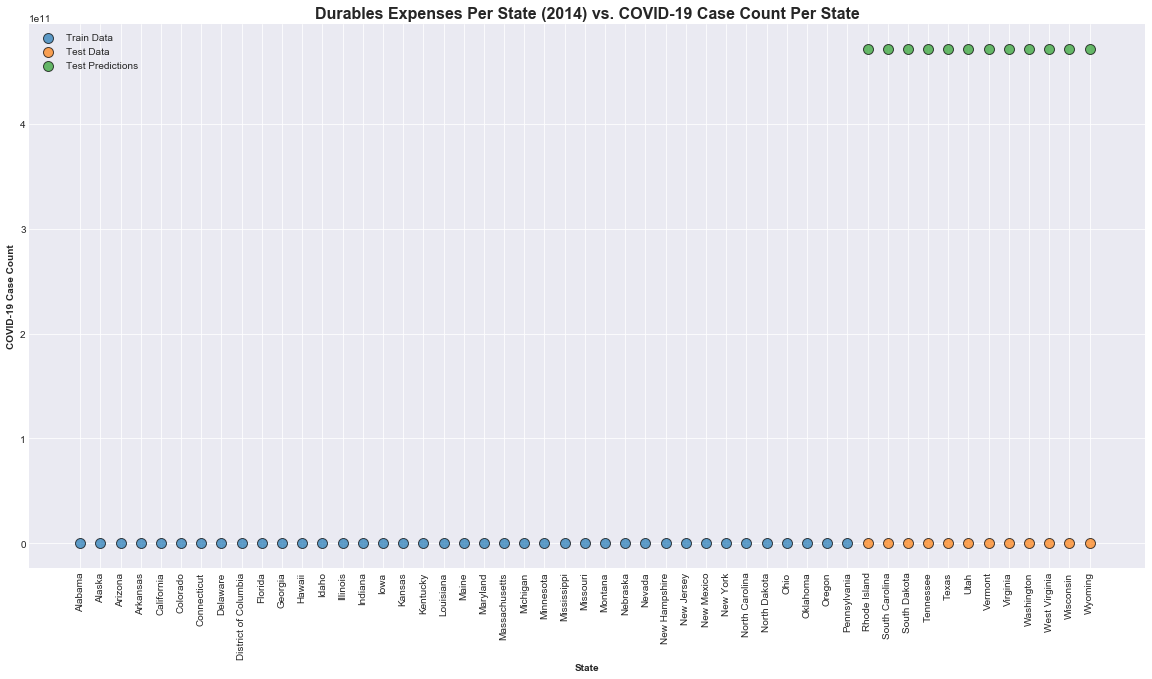

In [24]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Durables Expenses Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [25]:
features_list = ['Other Health Care Expenses Per State (2014)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 582426434611.0834
MSE Value: 3.3922055173396235e+23
RMS Value: 582426434611.2411
R2 Score: -1844947806649.3289


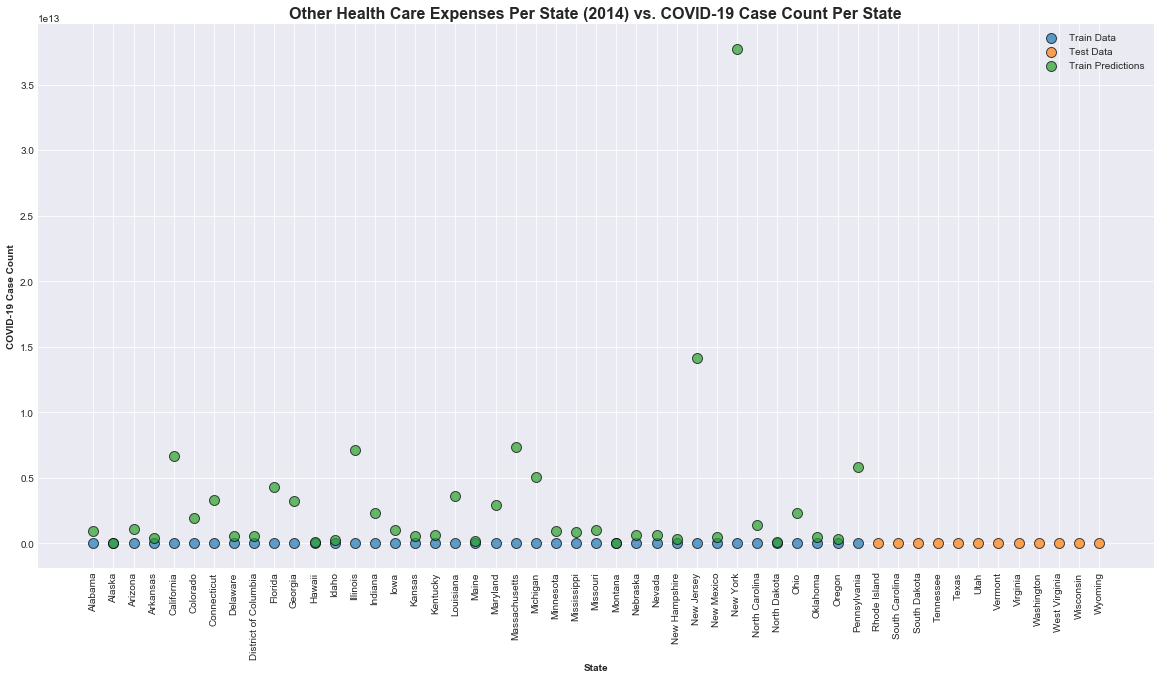

In [26]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Other Health Care Expenses Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

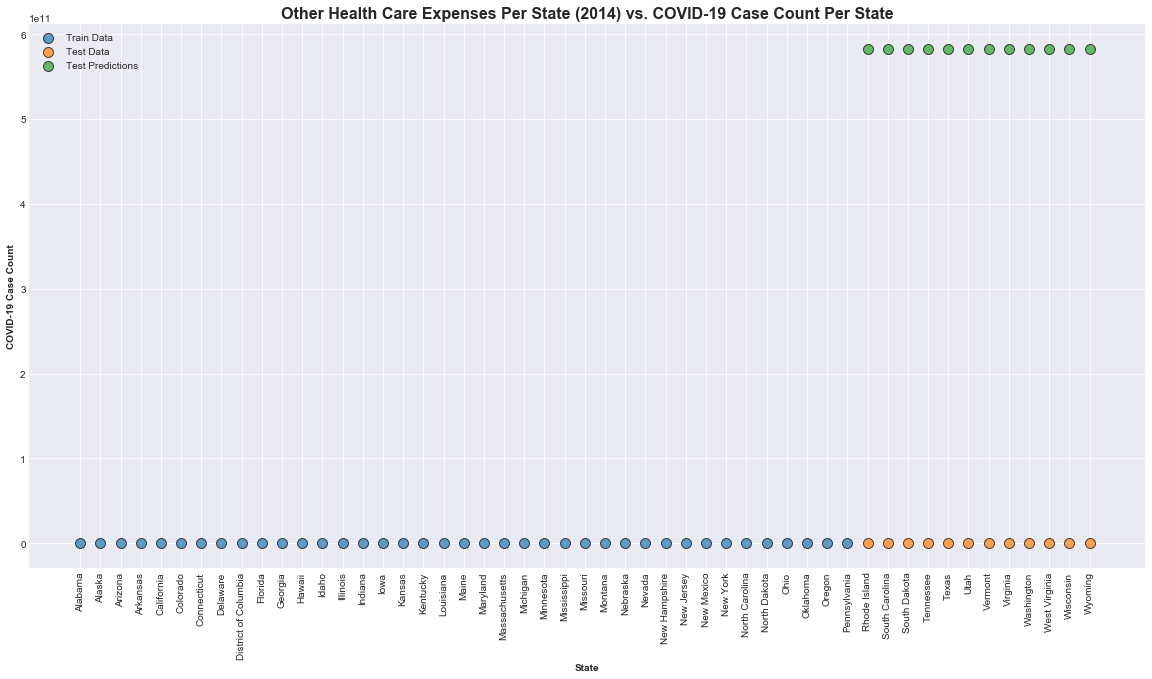

In [27]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Other Health Care Expenses Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [28]:
features_list = ['Personal Health Care Expenses Per State (2014)', 'Hospital Services Expenses Per State (2014)', 'Physician and Clinical Services Expenses Per State (2014)', 
           'Other Professional Services Expenses Per State (2014)', 'Home Health Care Expenses Per State (2014)', 
           'Drugs and Non-Durables Expenses Per State (2014)', 'Durables Expenses Per State (2014)', 
           'Other Health Care Expenses Per State (2014)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(X_test)

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)




MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 774033535368.4166
MSE Value: 5.998247564442105e+23
RMS Value: 774483541751.6698
R2 Score: -3262318167691.308


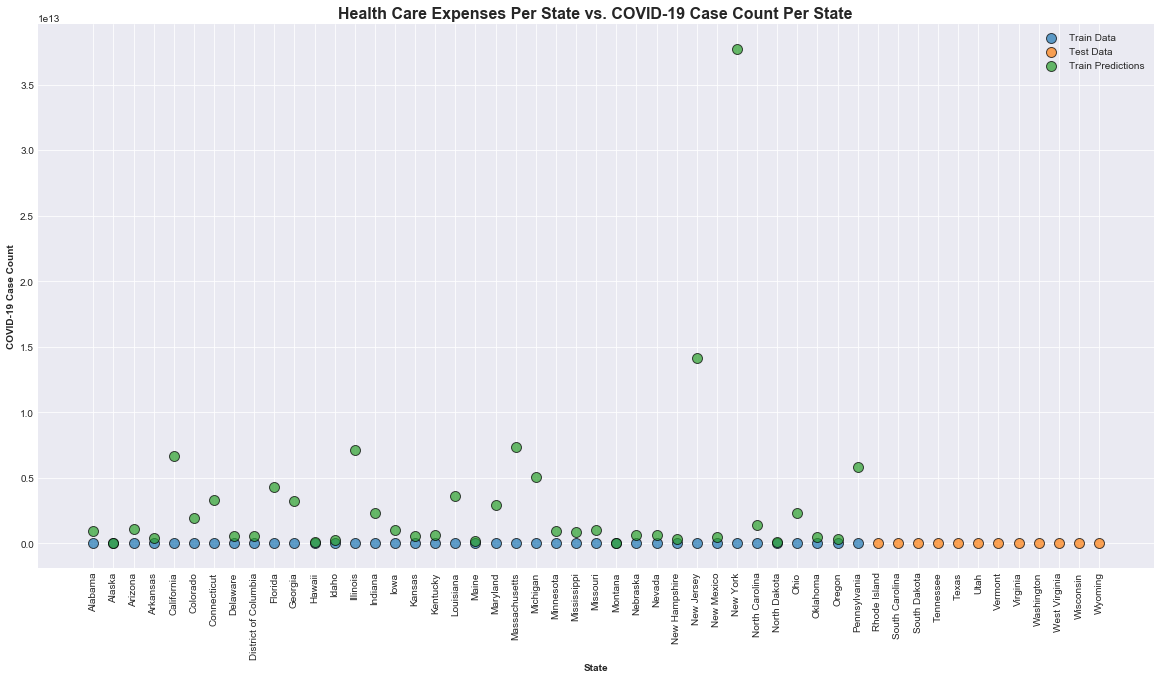

In [29]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Health Care Expenses Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

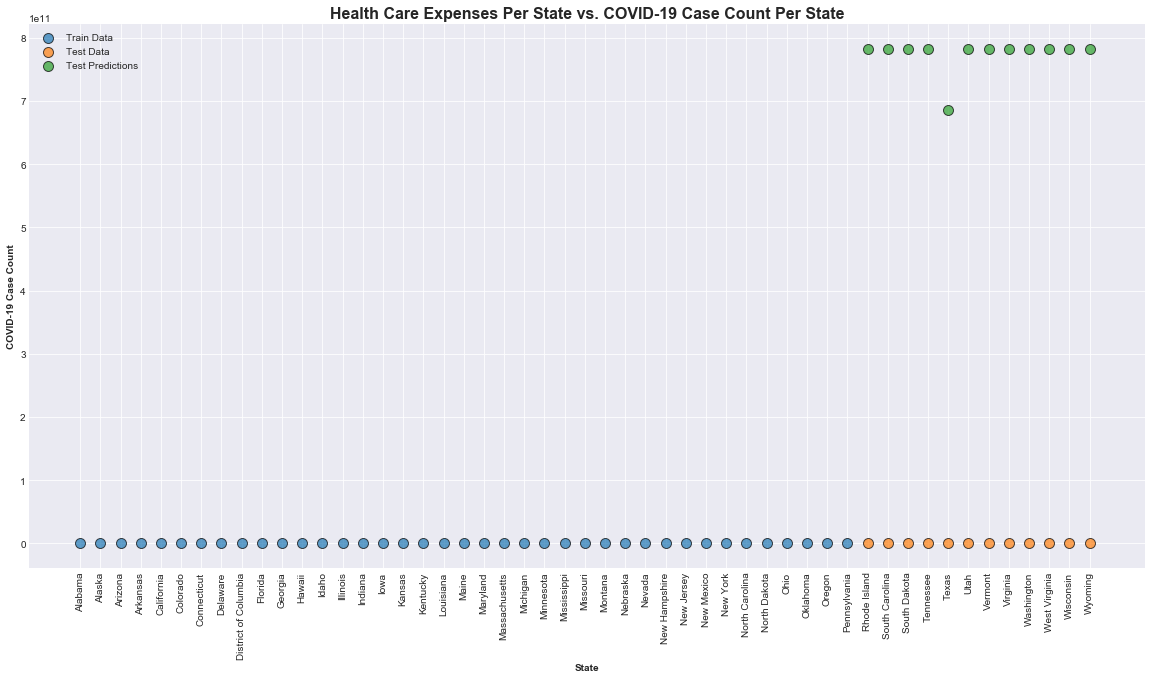

In [30]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Health Care Expenses Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();